In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import normalize

In [2]:
from numpy.random import seed
seed(1)

# Data

We want a lognormal distribution, but we also want to vectorize the data samples. This is to mimic the situtation we eventually want to consider, which is the qGANs architecture. In the qGAN architecture, we are going to have  2𝑛  values to work with (with n being the number of qubits), so we model the target distribution by establishing bins for each value to go into. Here, the binning process is simple, where we put values into bins linearly from 0 - 15, where the last bin contains all the values beyond 15 (hence the small peak at the end).

In [3]:
# Number training data samples
N = 10000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

In [4]:
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1

In [5]:
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

(array([1563., 2169., 1636., 1134.,  793.,  574.,  405.,  318.,  254.,
         178.,  131.,  114.,   96.,  102.,   69.,  464.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

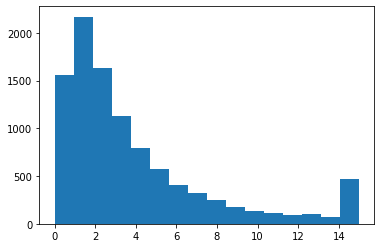

In [6]:
plt.hist(bin_indices, bins = 16)

In [7]:
data_process = []
for i in range(int(N)):
    idx = np.random.randint(N, size=1000)
    temp = data_temp[idx]
    new_point = np.sum(temp, axis = 0)/1000
    data_process.append(new_point)
data_processed = np.array(data_process)

In [8]:
BATCH_SIZE = 100
data_loader = DataLoader(data_processed, batch_size=BATCH_SIZE, shuffle=True)

# Networks

Simple classical discriminator

## Discriminator

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

## Generator

Here we define how many qubits, and the depth of the variational circuit

In [10]:
n_qubits = 4
# size = 100
q_depth = 3

In [11]:
dev = qml.device("default.qubit", wires= n_qubits)

Here we define how the variational circuit looks like.

We use all three rotations here, as well as circular entanglement with CNOTs.

Finally, the measurement gives us the probability of each possible 16 values (since it is a simulator, it will be the perfect one).

In [12]:
@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):
    #qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    #qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits),rotation= qml.RY)
    
    # Init distribution
    for a in range(n_qubits):
        qml.Hadamard(wires=a)
    
    # Actual distribution
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RX(weights[2*(i*n_qubits + j)], wires=j)
            qml.RY(weights[2*(i*n_qubits + j) + 1], wires=j)
            
        for k in range(n_qubits):
            if (k == (n_qubits - 1)):
                qml.CZ(wires=[k,0])
            else:
                qml.CZ(wires=[k,k+1])
    
    for l in range(n_qubits):
        qml.RX(weights[(2*q_depth * n_qubits) + l], wires=l)
        qml.RY(weights[(2*q_depth * n_qubits) + l + 1], wires=l)
    
    return qml.probs(wires=range(n_qubits))

In [13]:
weight_shapes = {"weights": (2 * (q_depth +1) * n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=16)

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(qlayer)

    return model

In [15]:
generator = make_generator_model()


In [16]:
discriminator = make_discriminator_model()

In [17]:
noise = tf.random.normal([100, 4])

In [18]:
generator(noise)

<tf.Tensor: shape=(100, 16), dtype=float64, numpy=
array([[0.05218738, 0.11136407, 0.05608738, ..., 0.03863612, 0.00986499,
        0.06751728],
       [0.05218738, 0.11136407, 0.05608738, ..., 0.03863612, 0.00986499,
        0.06751728],
       [0.05218738, 0.11136407, 0.05608738, ..., 0.03863612, 0.00986499,
        0.06751728],
       ...,
       [0.05218738, 0.11136407, 0.05608738, ..., 0.03863612, 0.00986499,
        0.06751728],
       [0.05218738, 0.11136407, 0.05608738, ..., 0.03863612, 0.00986499,
        0.06751728],
       [0.05218738, 0.11136407, 0.05608738, ..., 0.03863612, 0.00986499,
        0.06751728]])>

# Cost function

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)

# Training

In [23]:
EPOCHS = 200
noise_dim = n_qubits
num_examples_to_generate = 100
#BUFFER_SIZE = 60000


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        test_data = generator(seed, training=False).numpy()
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        y = range(16)
        ax.bar(y, test_data[0] )
        plt.show()
        
        for n_batch, batch in enumerate(dataset):
            X_batch = tf.convert_to_tensor(batch.numpy())
            train_step(X_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

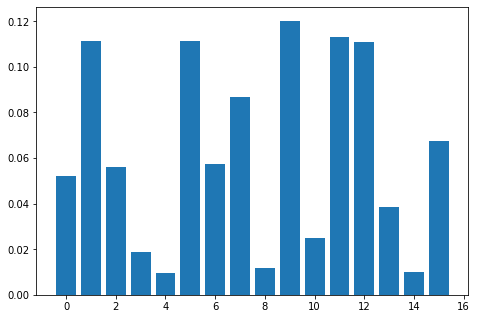

Time for epoch 1 is 900.332658290863 sec


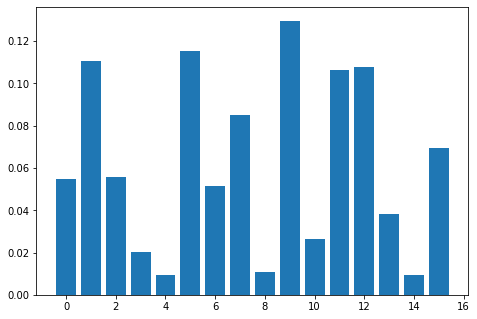

Time for epoch 2 is 11.489682912826538 sec


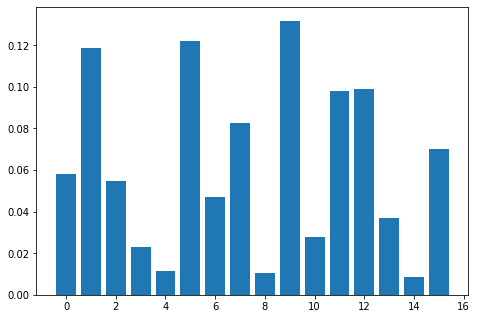

Time for epoch 3 is 10.686723232269287 sec


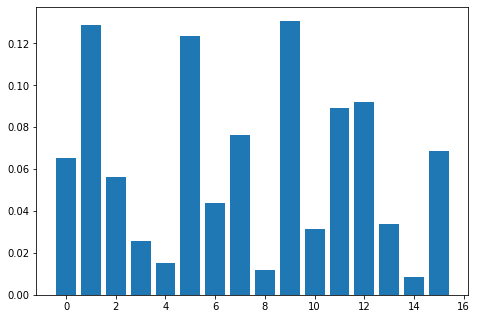

Time for epoch 4 is 10.91613221168518 sec


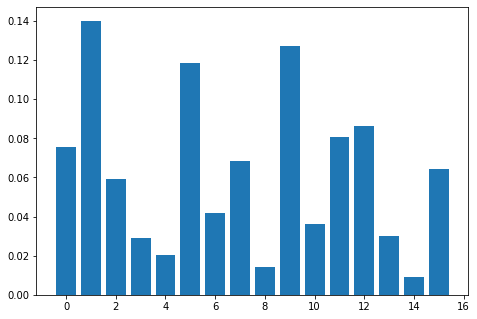

Time for epoch 5 is 10.653369903564453 sec


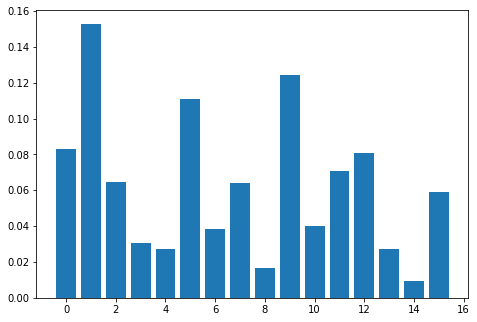

Time for epoch 6 is 10.848177671432495 sec


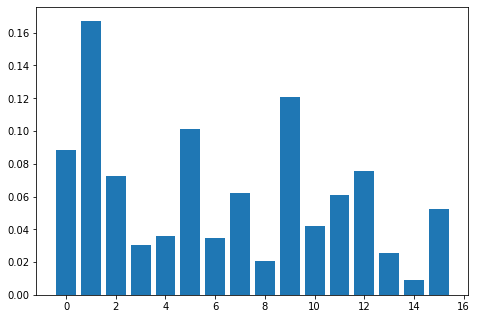

Time for epoch 7 is 10.788130760192871 sec


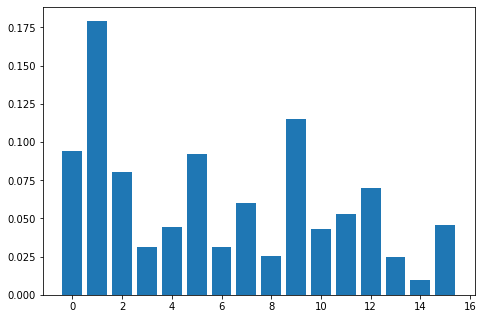

Time for epoch 8 is 10.807732582092285 sec


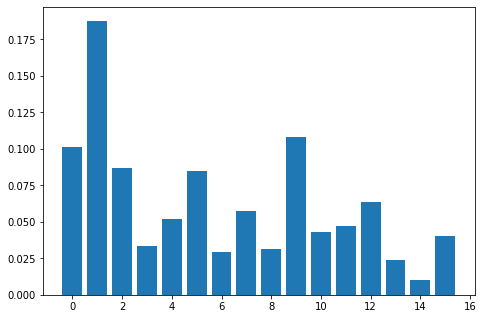

Time for epoch 9 is 11.128408432006836 sec


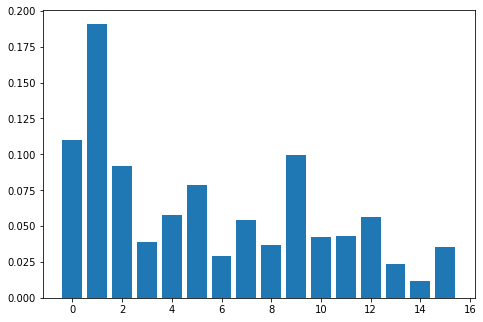

Time for epoch 10 is 11.387037992477417 sec


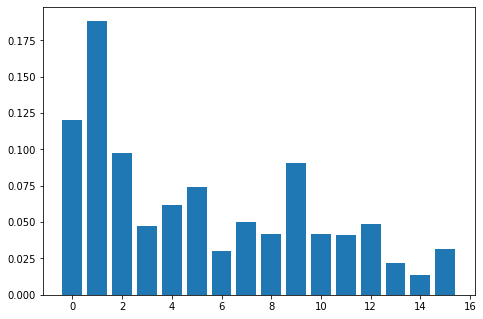

Time for epoch 11 is 10.747556686401367 sec


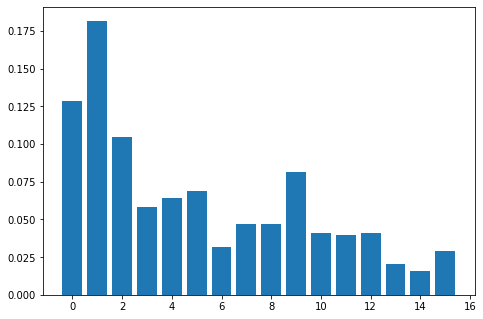

Time for epoch 12 is 10.777985572814941 sec


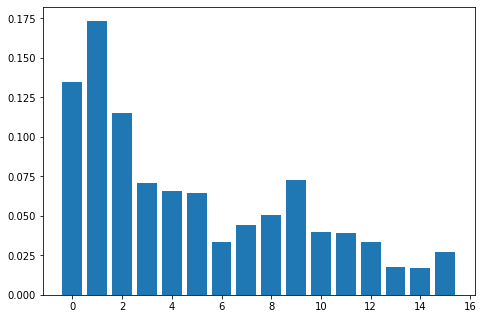

Time for epoch 13 is 10.848267793655396 sec


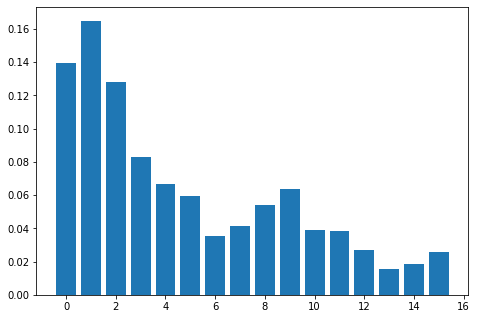

Time for epoch 14 is 10.893950939178467 sec


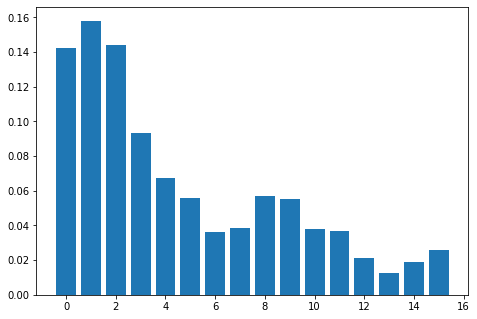

Time for epoch 15 is 10.707610130310059 sec


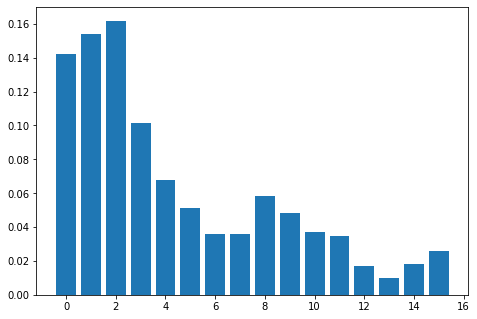

Time for epoch 16 is 10.686259746551514 sec


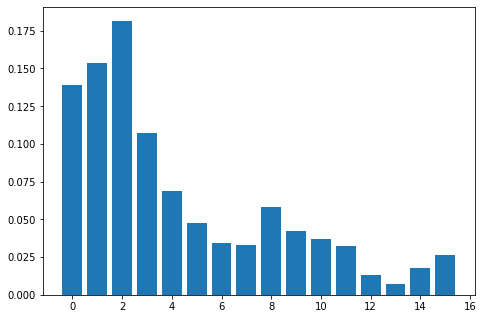

Time for epoch 17 is 10.603286504745483 sec


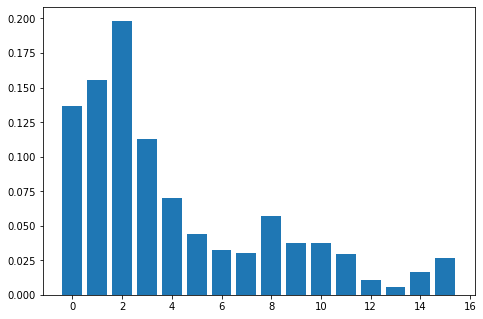

Time for epoch 18 is 10.812713384628296 sec


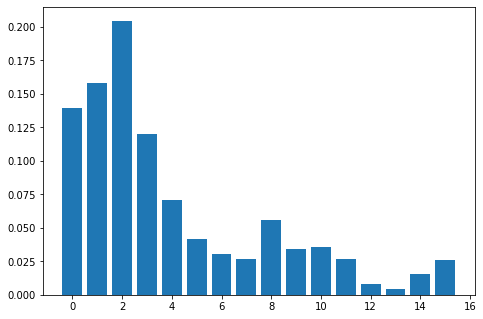

Time for epoch 19 is 10.692512035369873 sec


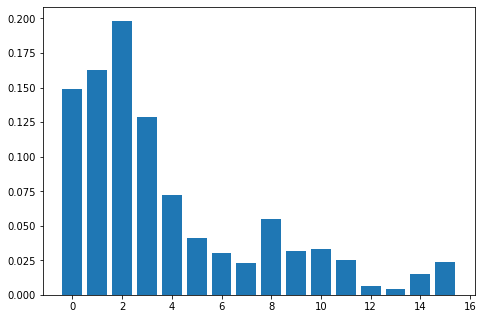

Time for epoch 20 is 10.695790767669678 sec


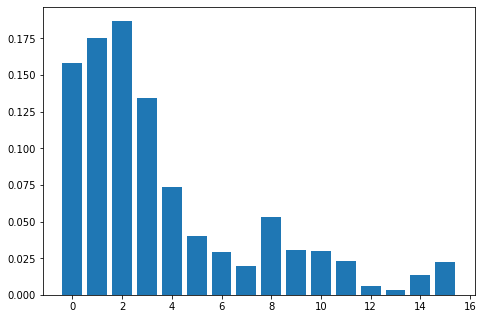

Time for epoch 21 is 10.758464574813843 sec


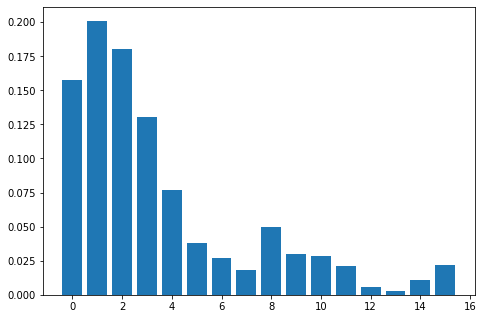

Time for epoch 22 is 10.908923149108887 sec


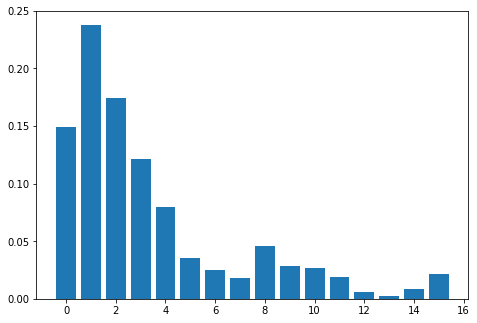

Time for epoch 23 is 11.351696491241455 sec


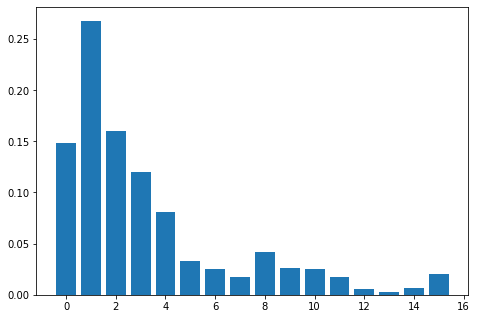

Time for epoch 24 is 10.581024169921875 sec


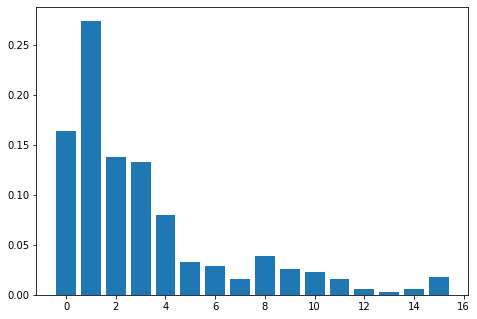

Time for epoch 25 is 12.551645994186401 sec


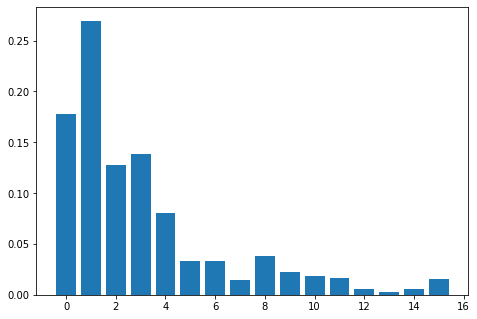

Time for epoch 26 is 12.009684324264526 sec


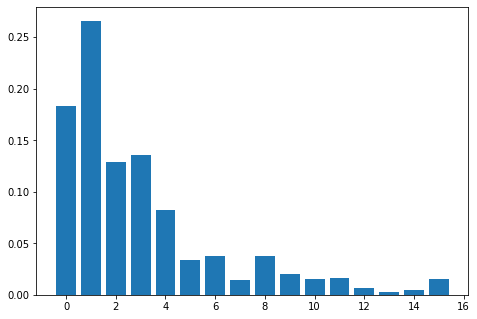

Time for epoch 27 is 11.408306121826172 sec


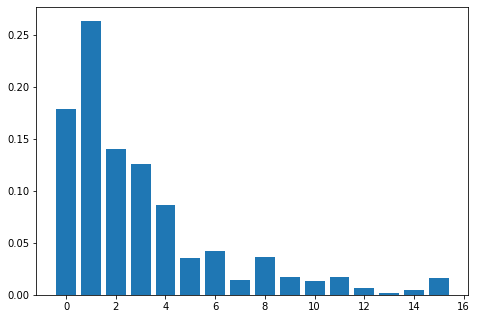

Time for epoch 28 is 10.906508684158325 sec


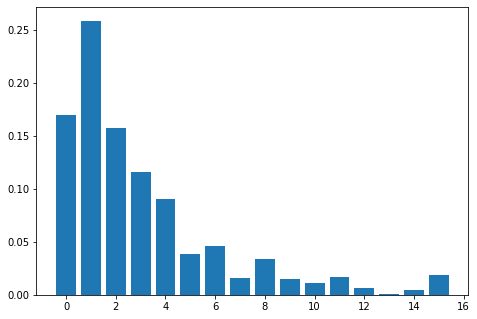

Time for epoch 29 is 10.73772382736206 sec


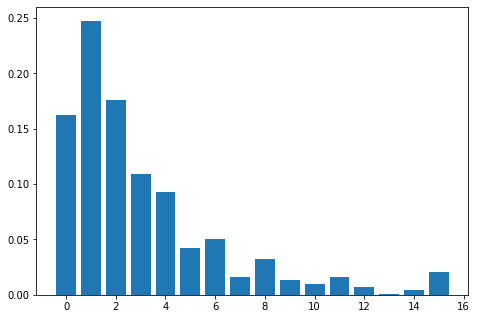

Time for epoch 30 is 10.686542272567749 sec


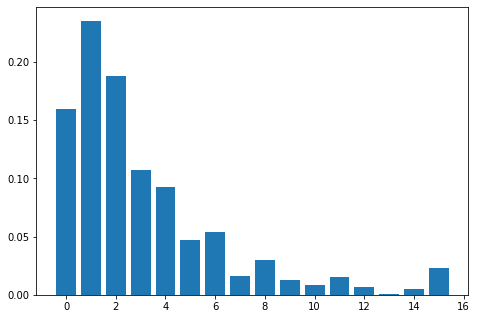

Time for epoch 31 is 10.922345638275146 sec


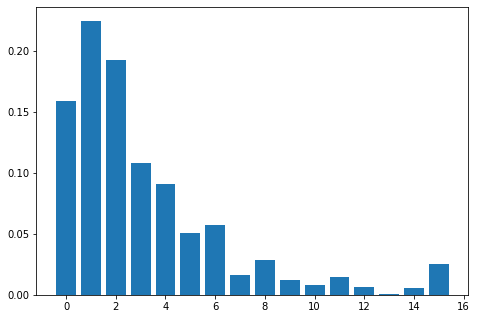

Time for epoch 32 is 10.676395654678345 sec


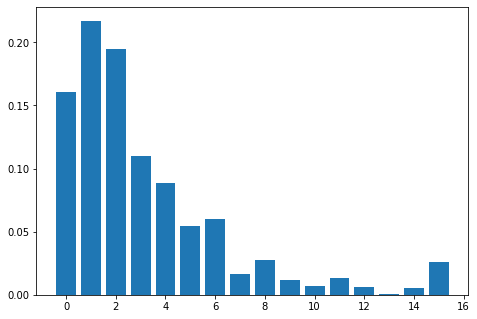

Time for epoch 33 is 10.823168992996216 sec


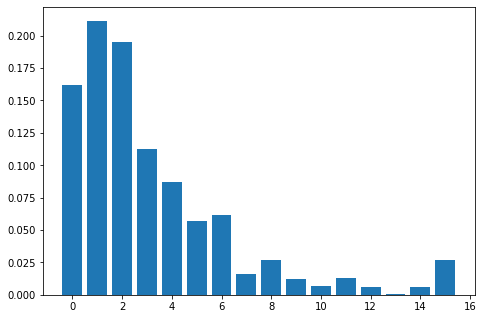

Time for epoch 34 is 11.00294303894043 sec


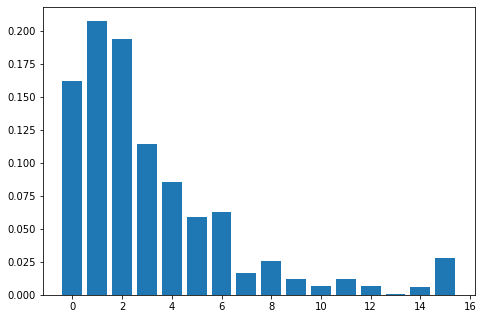

Time for epoch 35 is 10.785300970077515 sec


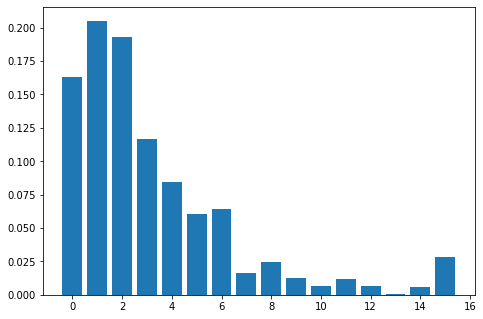

Time for epoch 36 is 10.688127994537354 sec


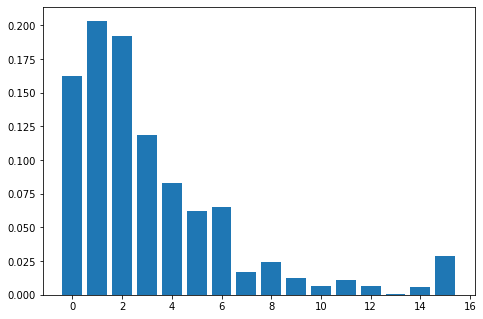

Time for epoch 37 is 10.775630235671997 sec


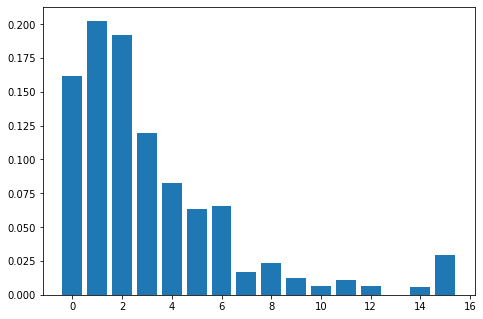

Time for epoch 38 is 12.231741905212402 sec


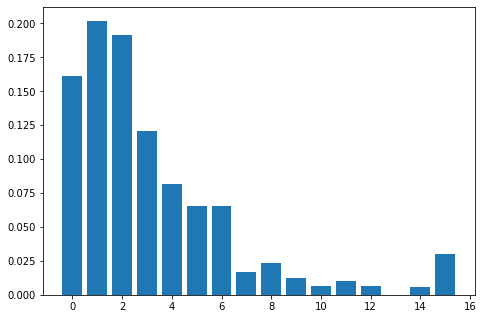

Time for epoch 39 is 12.165559768676758 sec


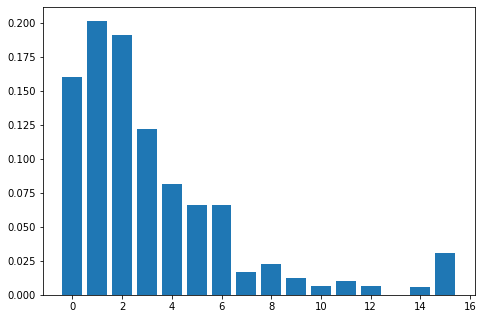

Time for epoch 40 is 11.054303884506226 sec


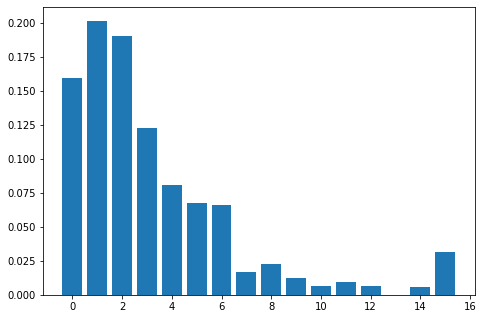

Time for epoch 41 is 11.29654598236084 sec


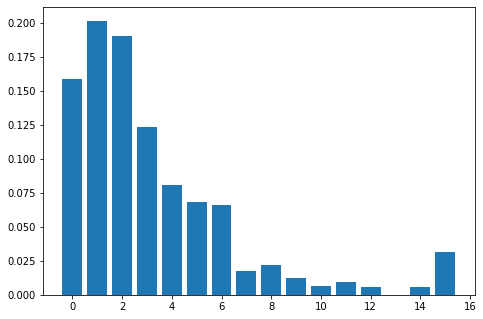

Time for epoch 42 is 10.863173246383667 sec


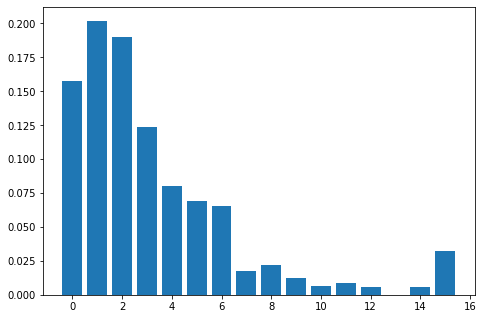

Time for epoch 43 is 10.56578779220581 sec


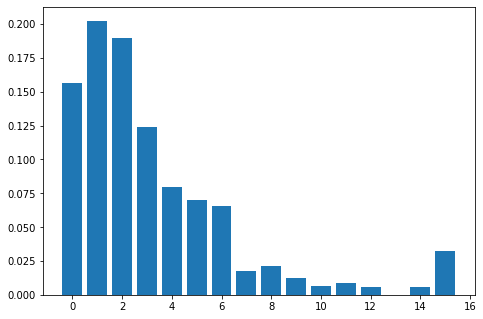

Time for epoch 44 is 10.813926935195923 sec


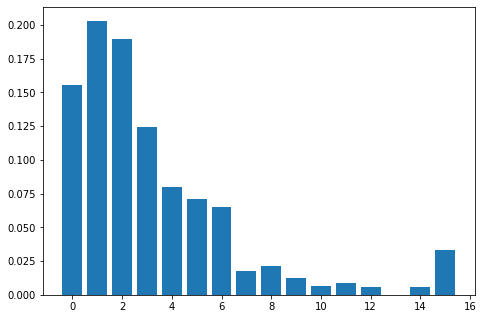

Time for epoch 45 is 11.121409177780151 sec


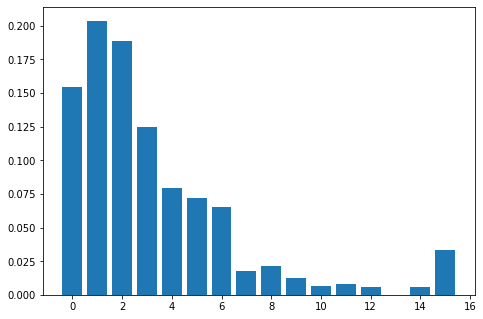

Time for epoch 46 is 10.641535997390747 sec


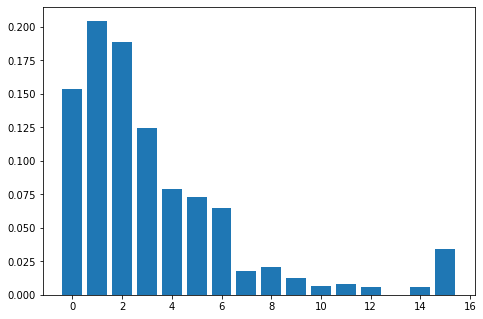

Time for epoch 47 is 10.819323301315308 sec


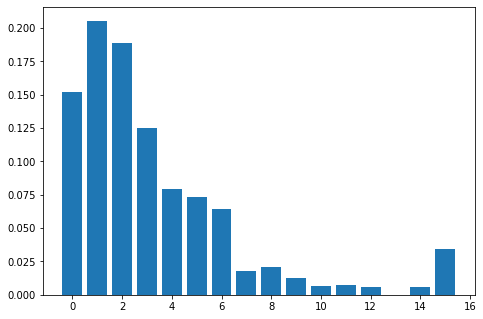

Time for epoch 48 is 10.70868992805481 sec


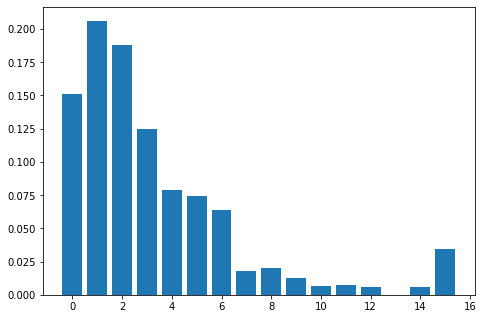

Time for epoch 49 is 10.68500018119812 sec


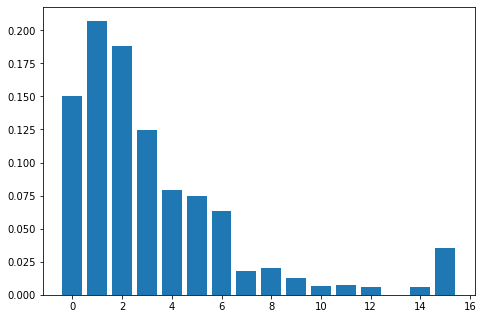

Time for epoch 50 is 10.889992475509644 sec


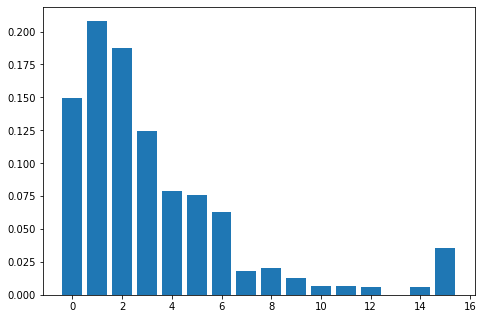

Time for epoch 51 is 10.896055459976196 sec


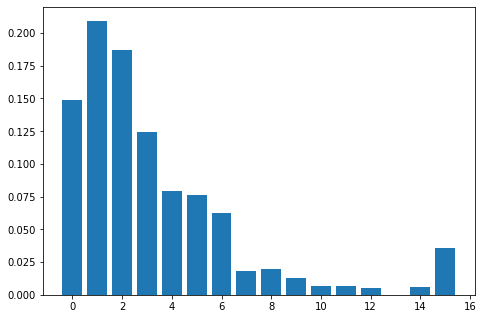

Time for epoch 52 is 10.477935075759888 sec


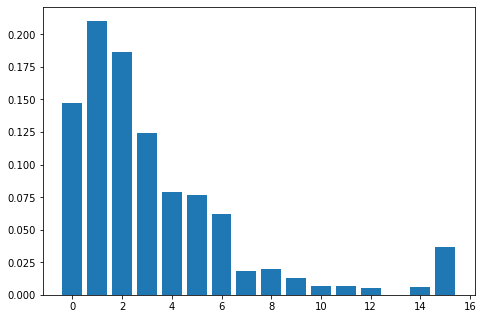

Time for epoch 53 is 10.67811918258667 sec


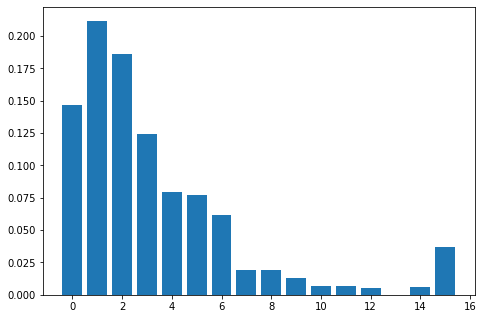

Time for epoch 54 is 10.641810417175293 sec


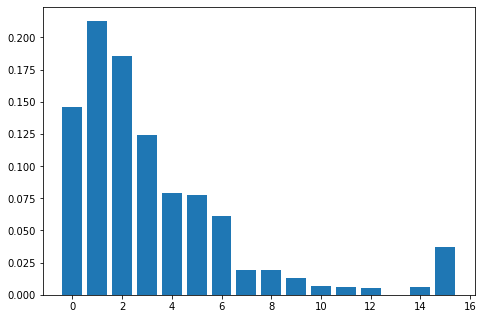

Time for epoch 55 is 11.24490237236023 sec


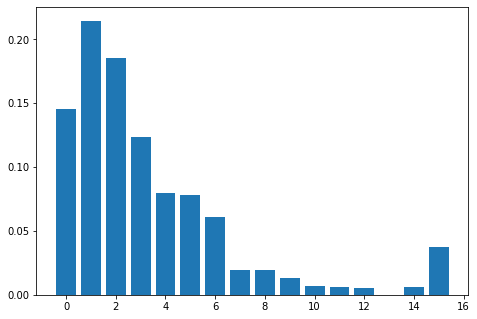

Time for epoch 56 is 10.696837186813354 sec


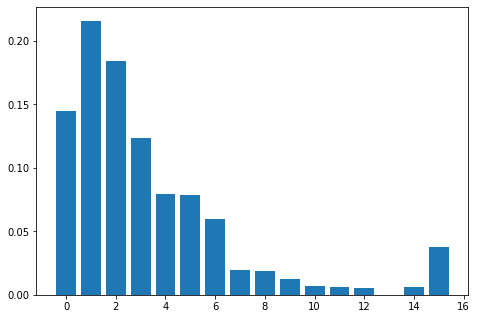

Time for epoch 57 is 11.043219566345215 sec


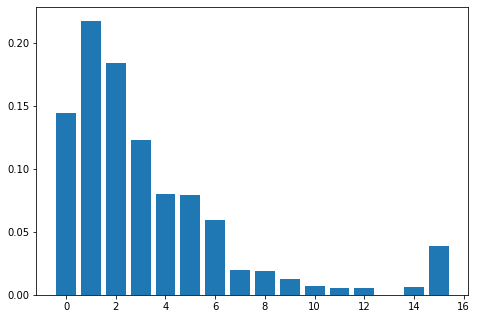

Time for epoch 58 is 12.998582363128662 sec


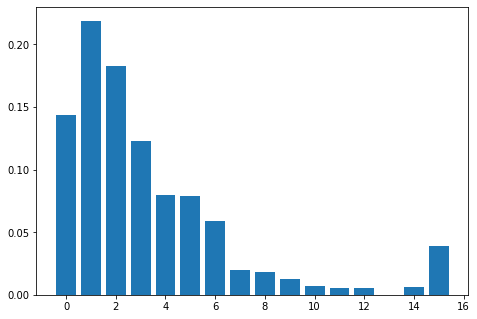

Time for epoch 59 is 11.220279932022095 sec


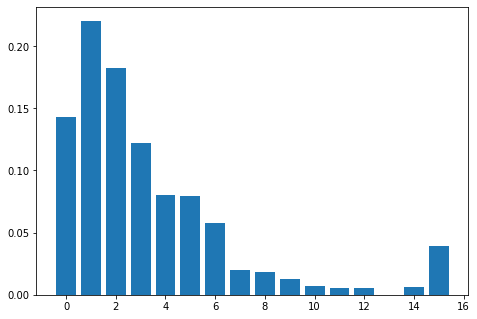

Time for epoch 60 is 10.843063354492188 sec


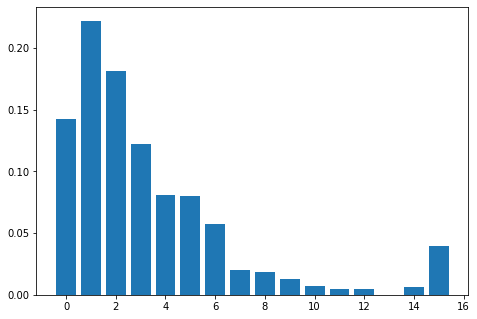

Time for epoch 61 is 11.753144264221191 sec


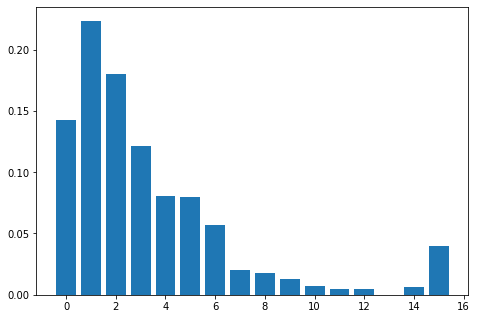

Time for epoch 62 is 11.066851377487183 sec


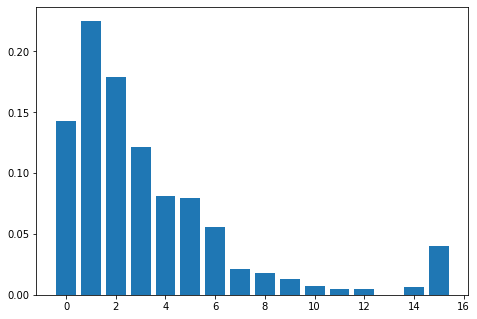

Time for epoch 63 is 11.548506736755371 sec


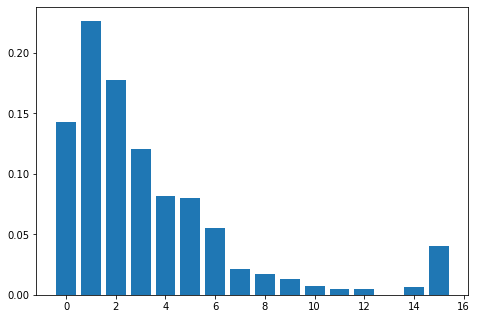

Time for epoch 64 is 11.53748869895935 sec


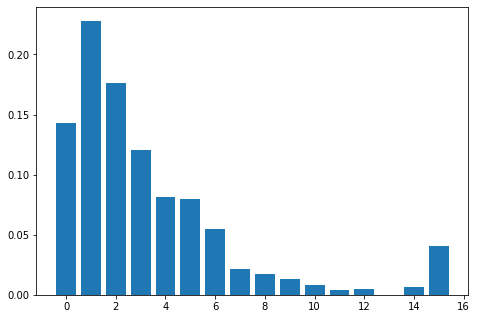

Time for epoch 65 is 10.732828378677368 sec


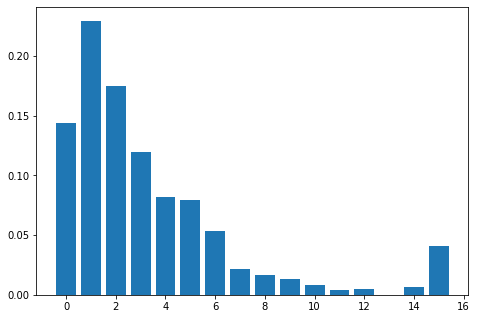

Time for epoch 66 is 10.6223886013031 sec


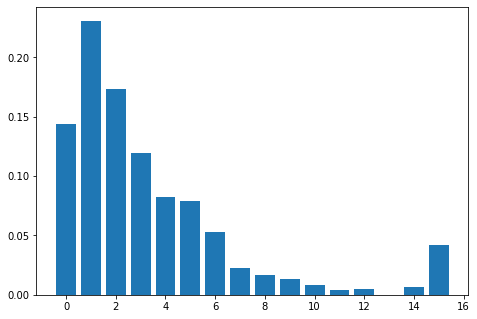

Time for epoch 67 is 10.580558061599731 sec


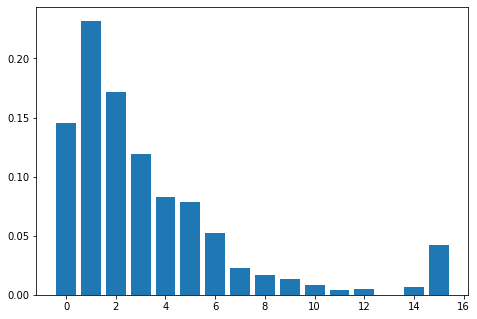

Time for epoch 68 is 10.570679426193237 sec


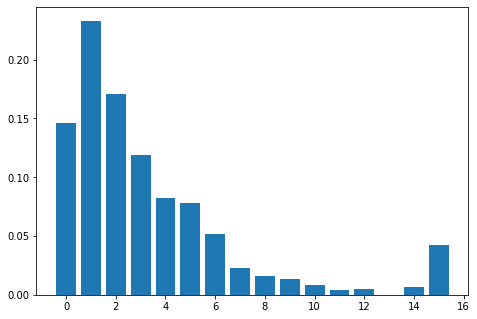

Time for epoch 69 is 10.792251348495483 sec


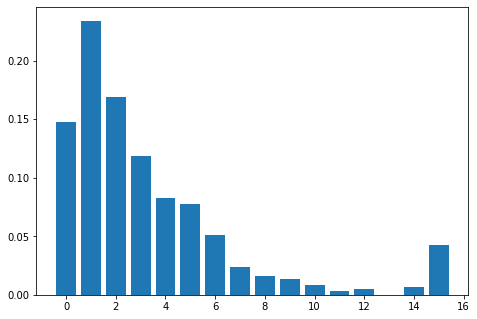

Time for epoch 70 is 10.662496566772461 sec


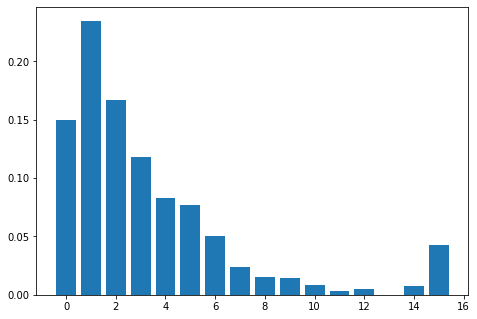

Time for epoch 71 is 10.700860977172852 sec


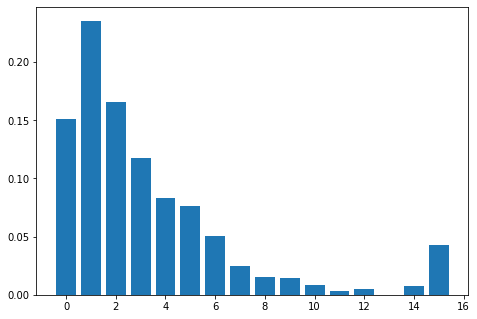

Time for epoch 72 is 10.579259395599365 sec


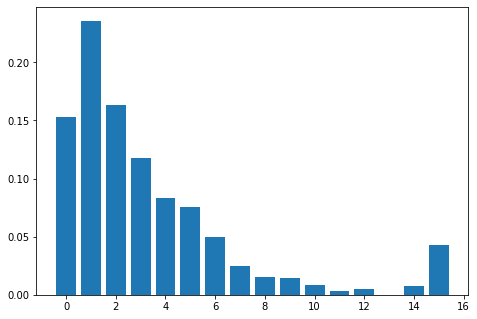

Time for epoch 73 is 10.58645486831665 sec


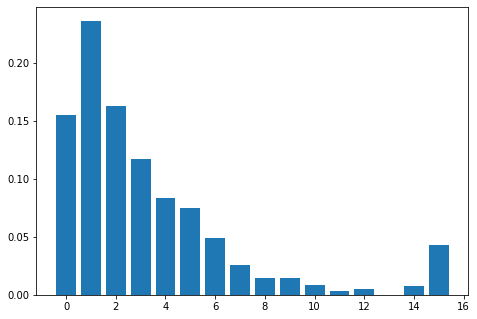

Time for epoch 74 is 10.519920825958252 sec


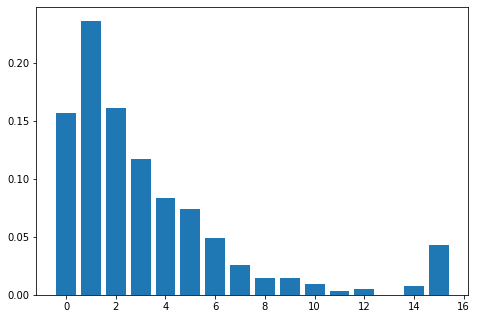

Time for epoch 75 is 10.752067565917969 sec


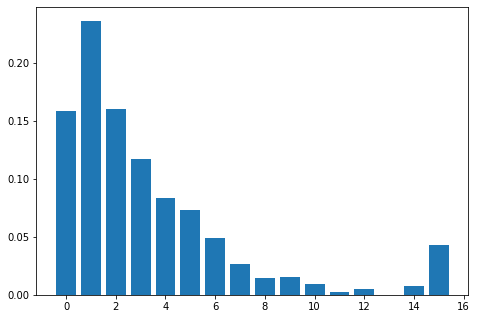

Time for epoch 76 is 11.628270387649536 sec


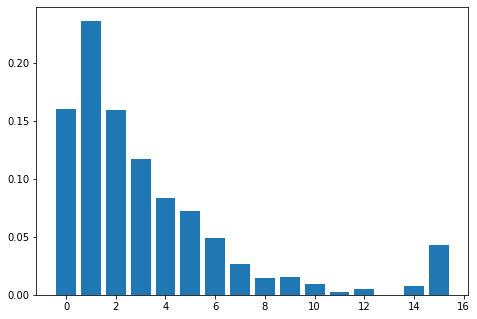

Time for epoch 77 is 11.937756538391113 sec


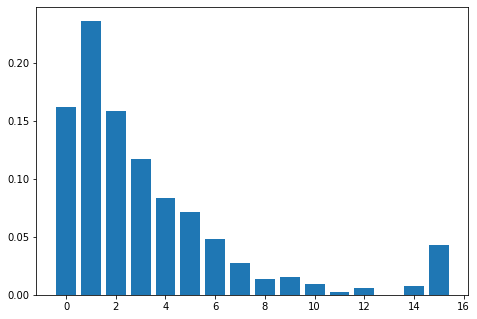

Time for epoch 78 is 10.605800867080688 sec


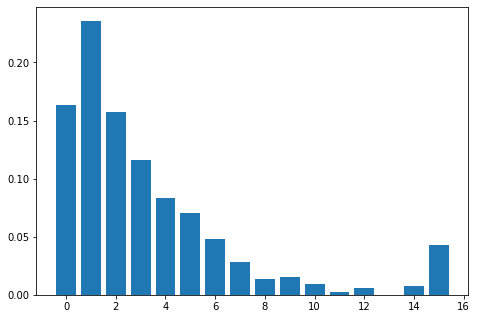

Time for epoch 79 is 10.899739265441895 sec


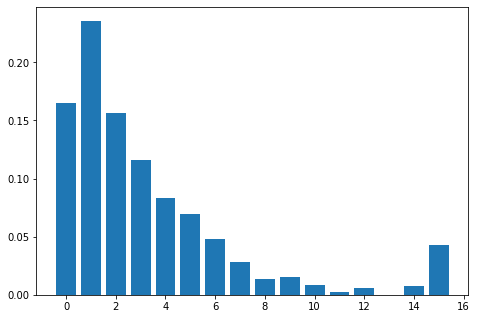

Time for epoch 80 is 10.892592430114746 sec


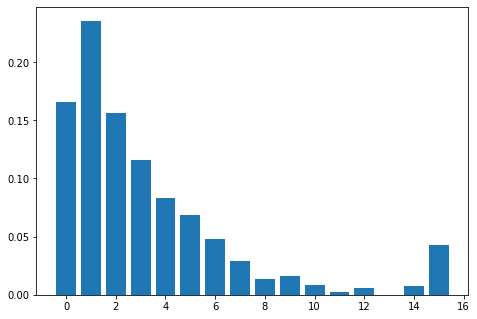

Time for epoch 81 is 10.467830896377563 sec


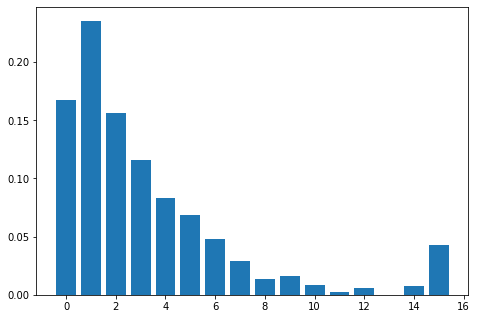

Time for epoch 82 is 10.869481801986694 sec


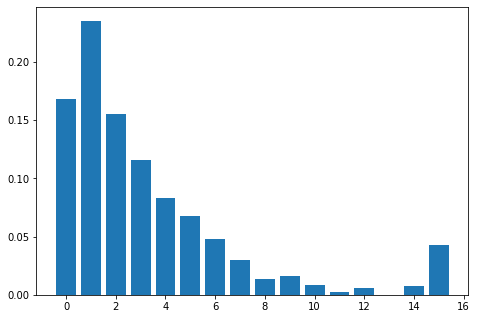

Time for epoch 83 is 11.195626020431519 sec


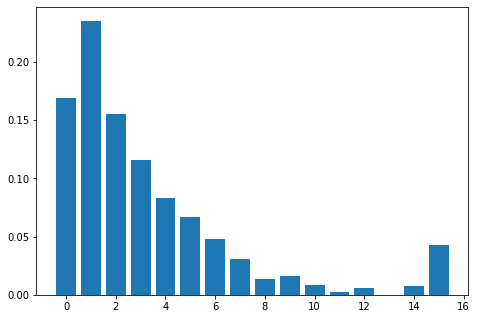

Time for epoch 84 is 11.409755945205688 sec


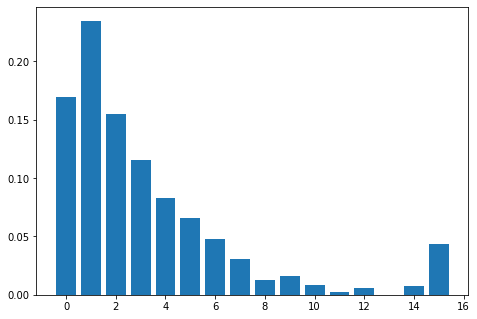

Time for epoch 85 is 10.798022985458374 sec


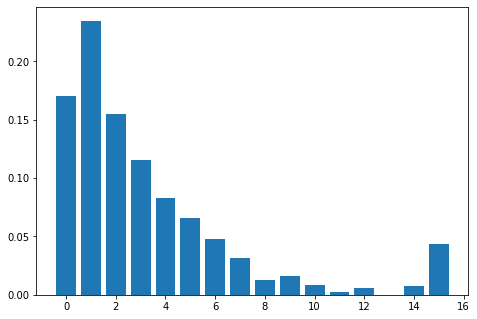

Time for epoch 86 is 10.727203607559204 sec


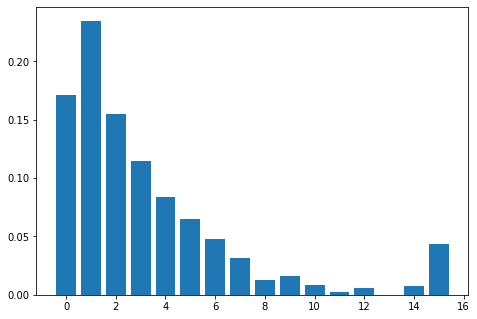

Time for epoch 87 is 10.544817447662354 sec


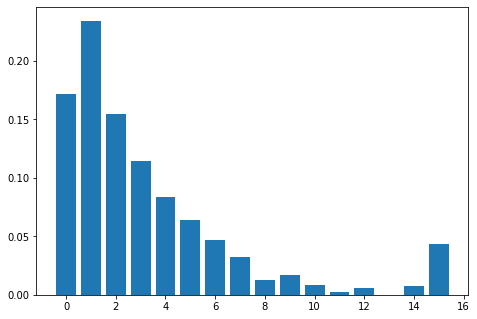

Time for epoch 88 is 10.706100940704346 sec


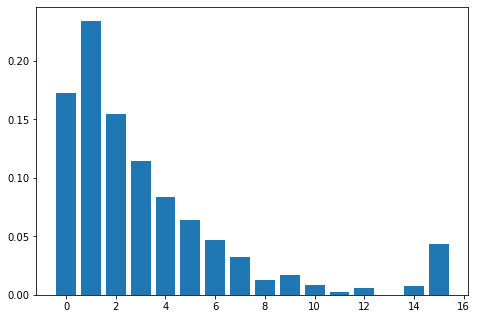

Time for epoch 89 is 10.792225360870361 sec


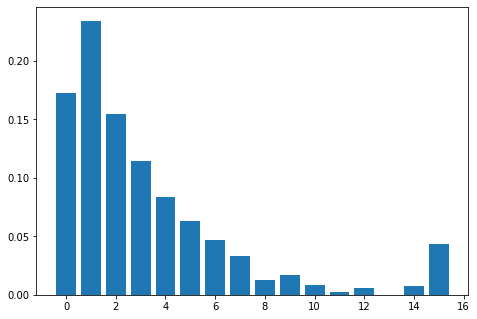

Time for epoch 90 is 10.515616655349731 sec


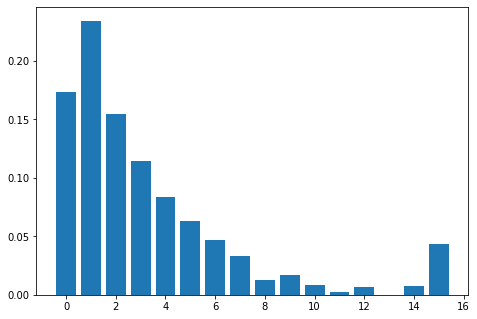

Time for epoch 91 is 10.45647668838501 sec


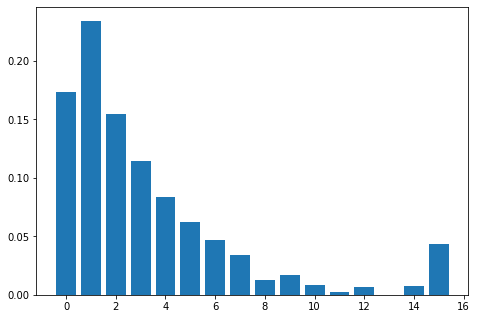

Time for epoch 92 is 10.826396226882935 sec


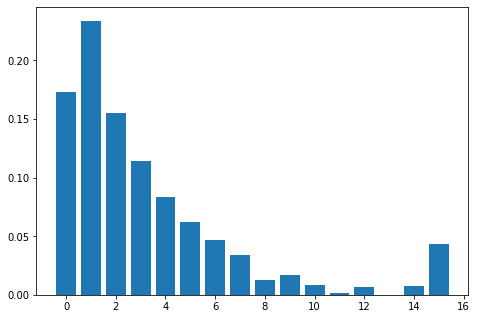

Time for epoch 93 is 10.677325010299683 sec


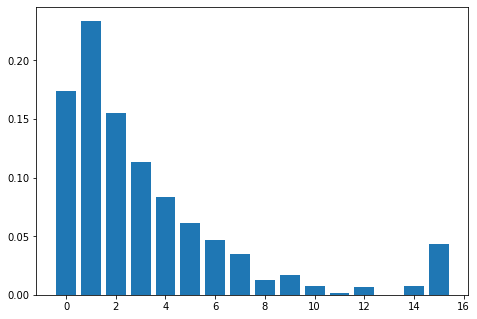

Time for epoch 94 is 10.636825323104858 sec


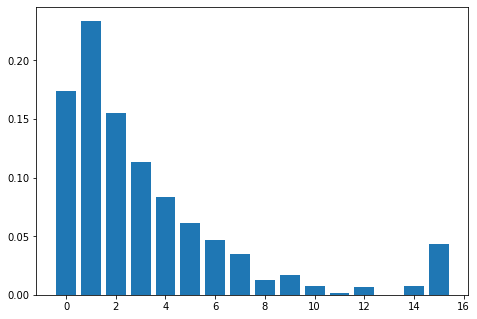

Time for epoch 95 is 10.838309526443481 sec


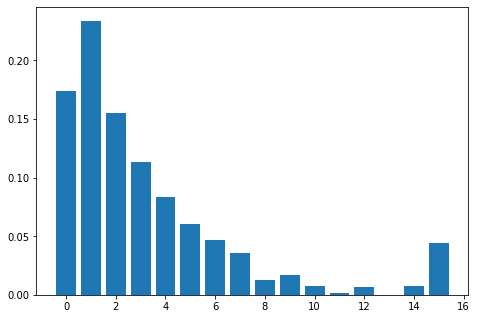

Time for epoch 96 is 10.501159906387329 sec


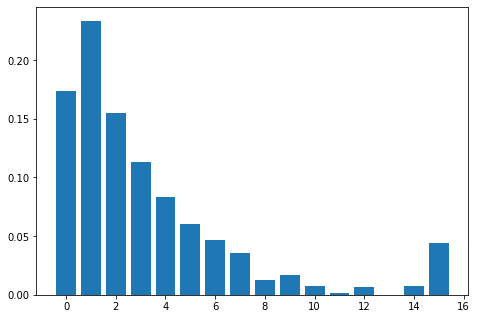

Time for epoch 97 is 10.59769058227539 sec


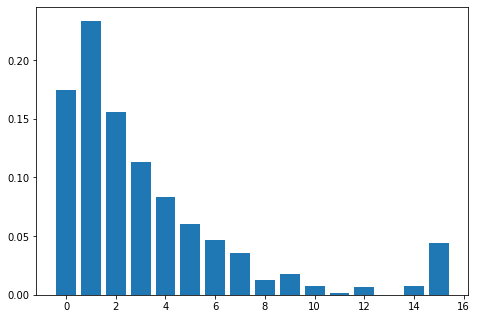

Time for epoch 98 is 10.759184122085571 sec


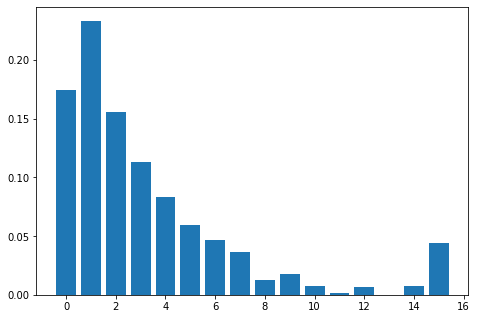

Time for epoch 99 is 10.569591522216797 sec


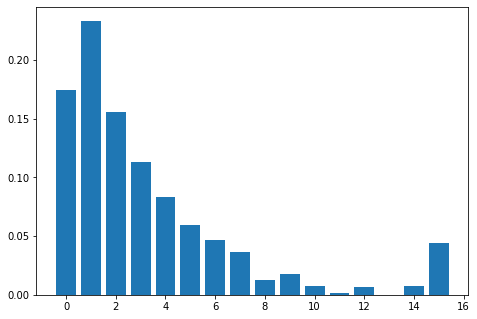

Time for epoch 100 is 10.68630337715149 sec


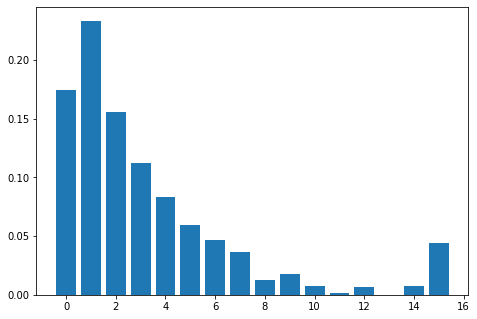

Time for epoch 101 is 10.651844024658203 sec


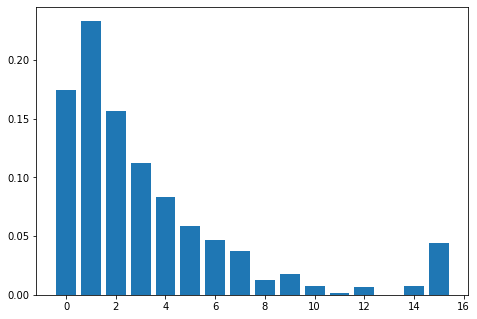

Time for epoch 102 is 10.59630012512207 sec


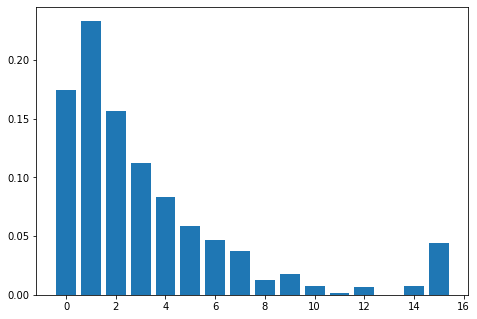

Time for epoch 103 is 10.657148361206055 sec


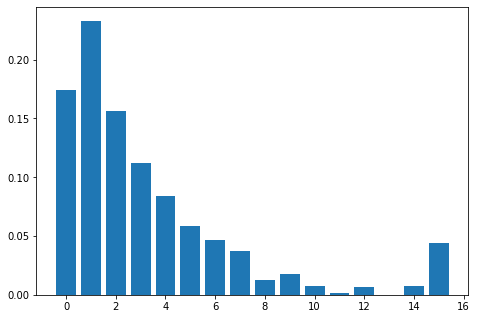

Time for epoch 104 is 10.730583429336548 sec


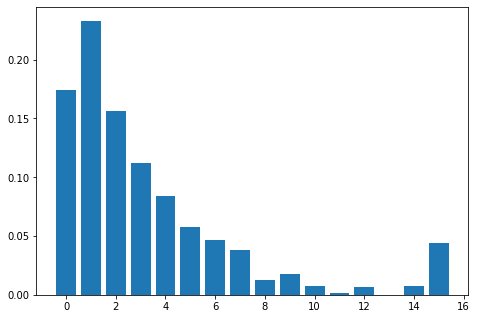

Time for epoch 105 is 10.371926069259644 sec


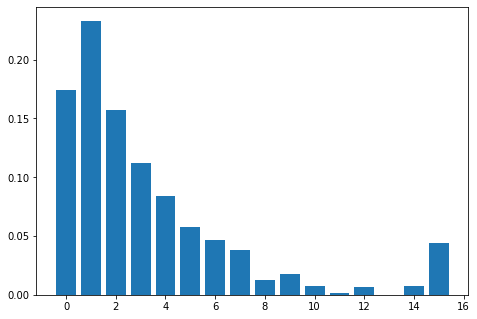

Time for epoch 106 is 10.623006820678711 sec


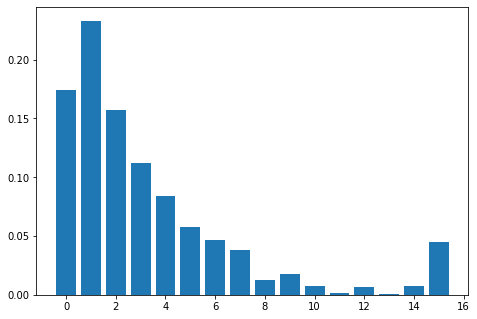

Time for epoch 107 is 10.755832195281982 sec


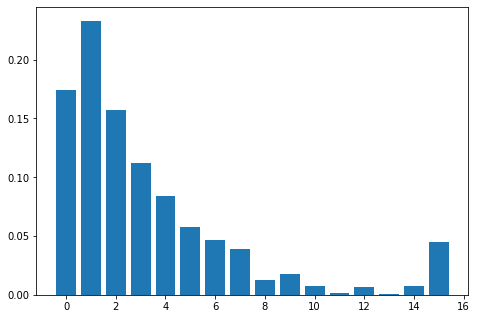

Time for epoch 108 is 10.507646560668945 sec


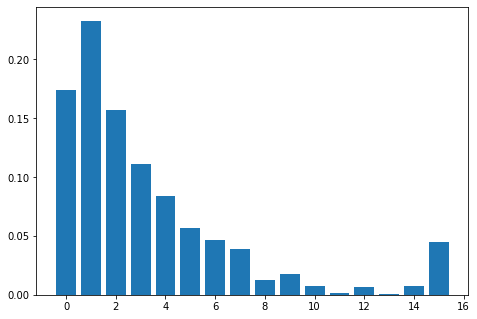

Time for epoch 109 is 10.955055236816406 sec


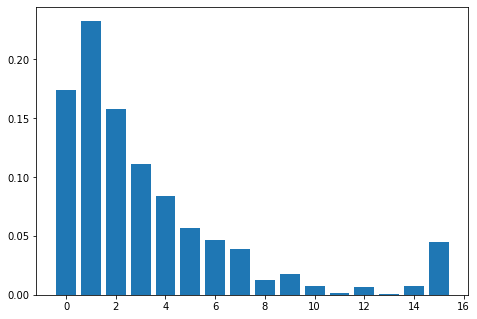

Time for epoch 110 is 10.629539966583252 sec


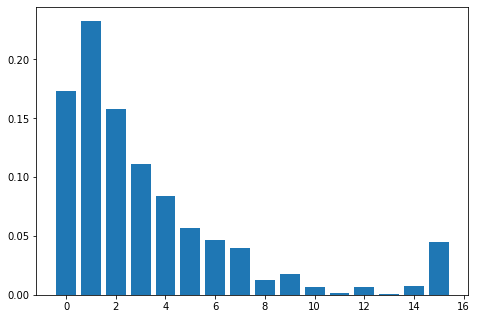

Time for epoch 111 is 10.588033199310303 sec


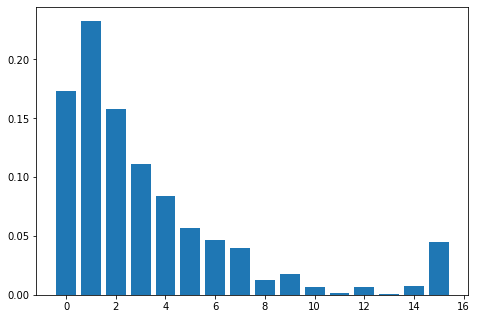

Time for epoch 112 is 10.558802366256714 sec


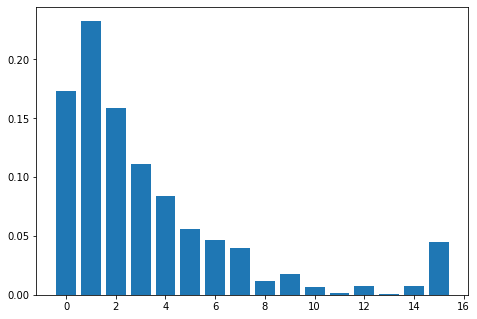

Time for epoch 113 is 10.627712965011597 sec


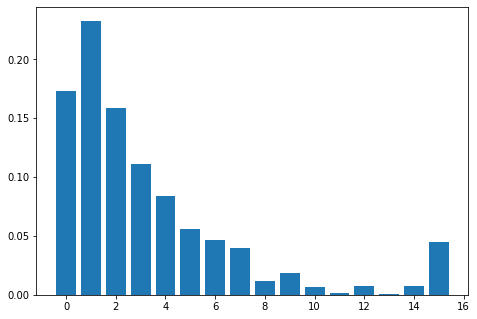

Time for epoch 114 is 10.449233055114746 sec


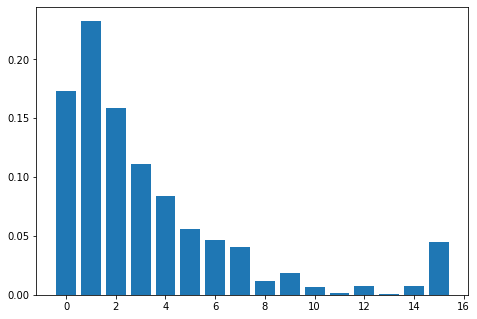

Time for epoch 115 is 10.566300392150879 sec


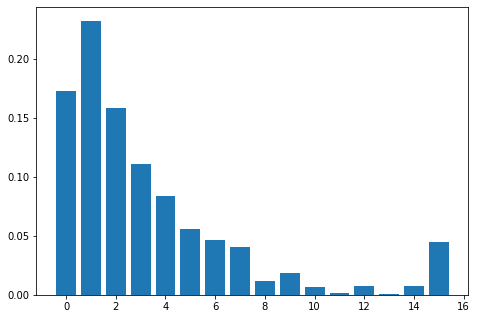

Time for epoch 116 is 10.638906002044678 sec


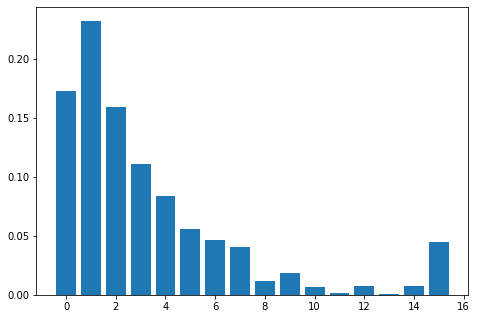

Time for epoch 117 is 10.659777164459229 sec


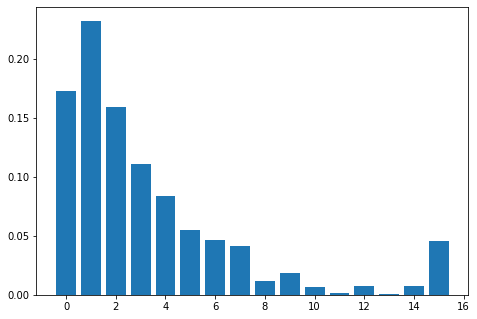

Time for epoch 118 is 10.627371788024902 sec


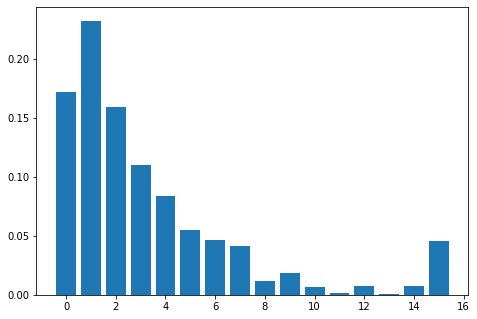

Time for epoch 119 is 11.614367961883545 sec


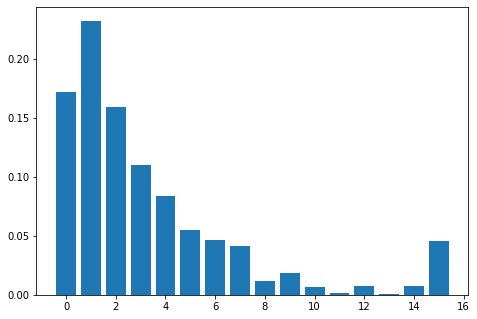

Time for epoch 120 is 10.282163858413696 sec


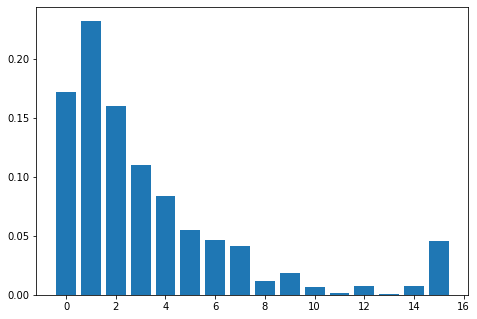

Time for epoch 121 is 11.079968214035034 sec


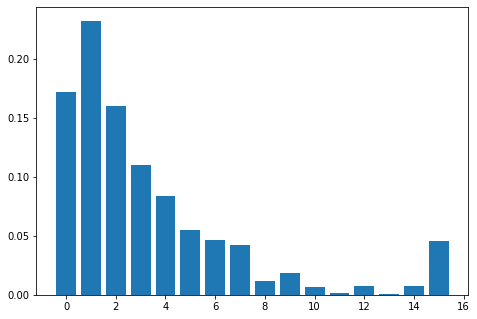

Time for epoch 122 is 10.874581098556519 sec


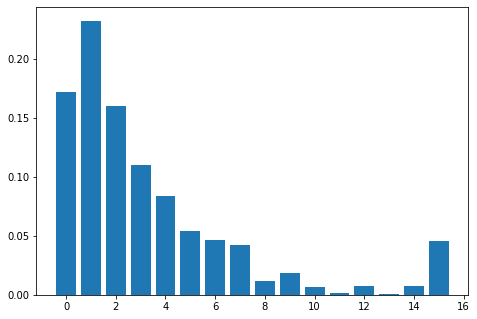

Time for epoch 123 is 11.534913063049316 sec


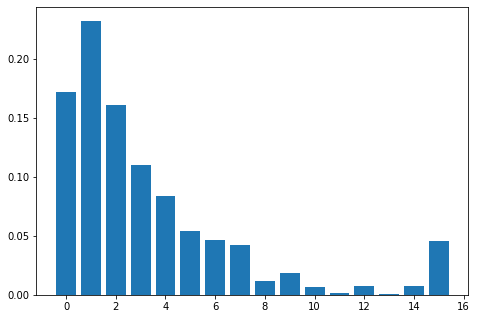

Time for epoch 124 is 11.901132583618164 sec


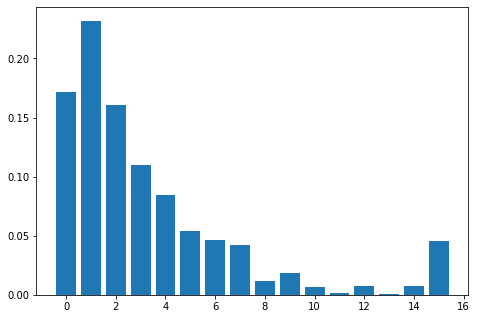

Time for epoch 125 is 12.037260055541992 sec


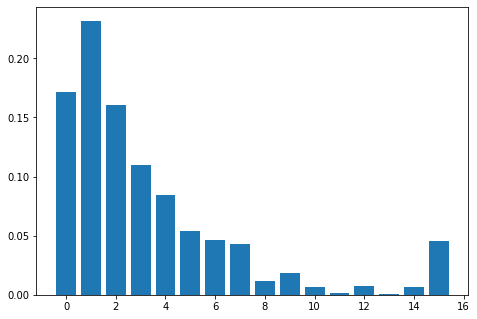

Time for epoch 126 is 11.645311117172241 sec


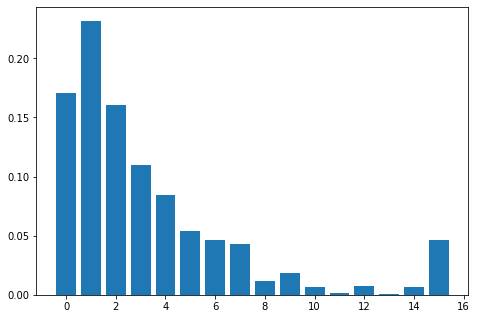

Time for epoch 127 is 10.812674283981323 sec


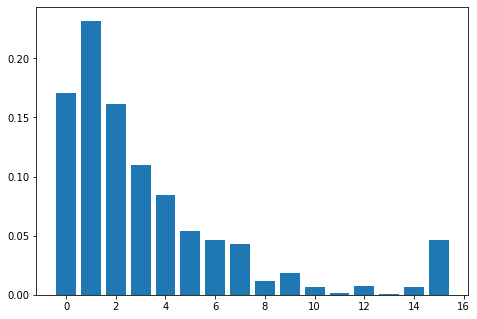

Time for epoch 128 is 10.634113073348999 sec


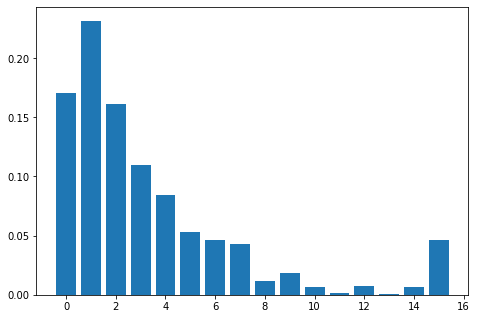

Time for epoch 129 is 10.628177881240845 sec


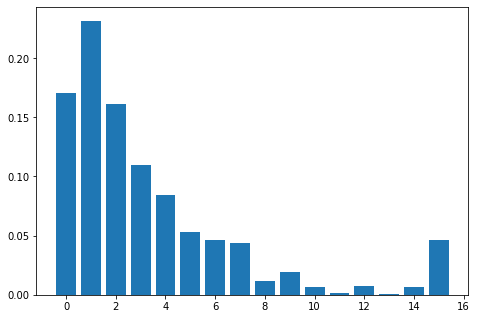

Time for epoch 130 is 10.569607019424438 sec


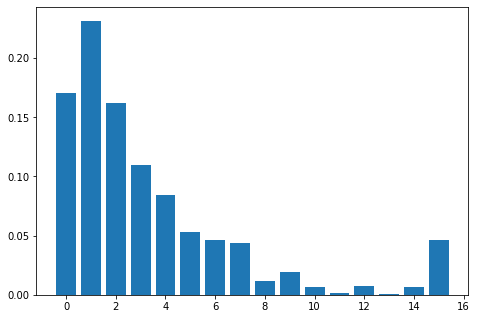

Time for epoch 131 is 10.50115418434143 sec


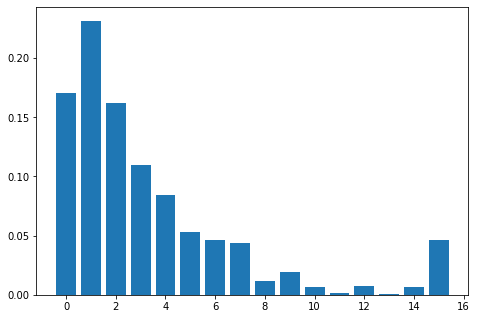

Time for epoch 132 is 10.543210983276367 sec


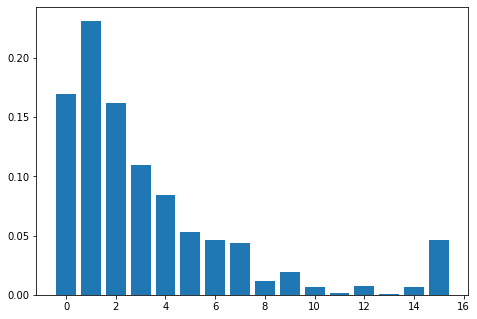

Time for epoch 133 is 10.392166376113892 sec


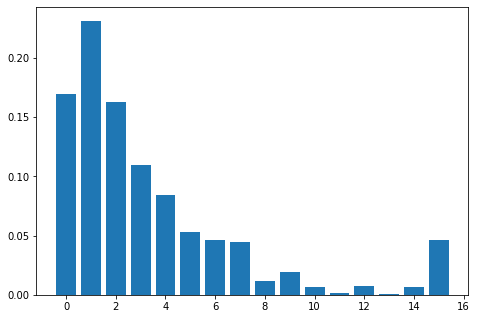

Time for epoch 134 is 10.604178667068481 sec


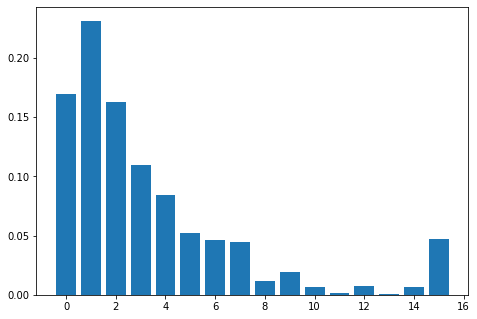

Time for epoch 135 is 10.53095006942749 sec


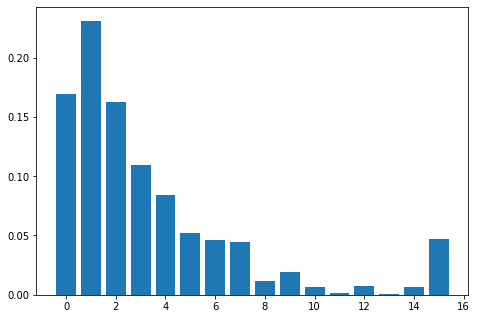

Time for epoch 136 is 10.47194766998291 sec


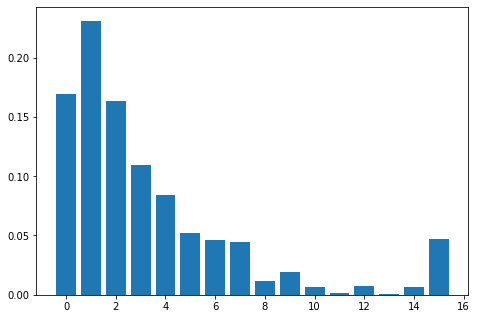

Time for epoch 137 is 10.416325092315674 sec


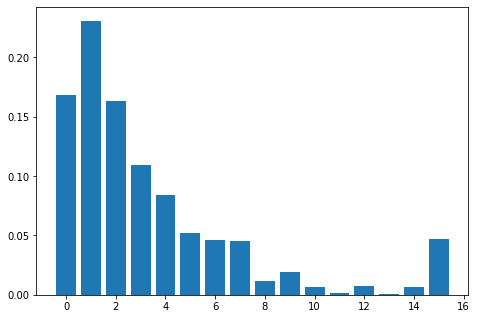

Time for epoch 138 is 10.54971981048584 sec


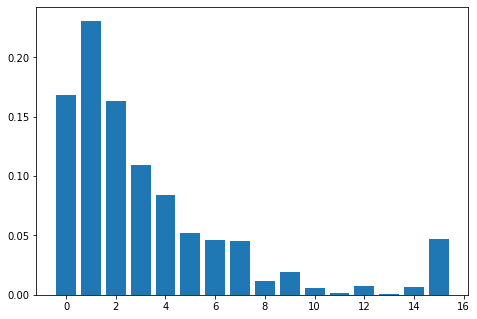

Time for epoch 139 is 10.405897378921509 sec


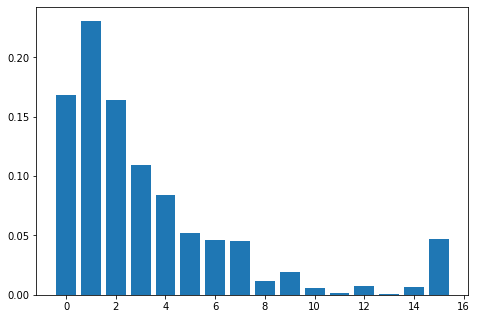

Time for epoch 140 is 10.500287055969238 sec


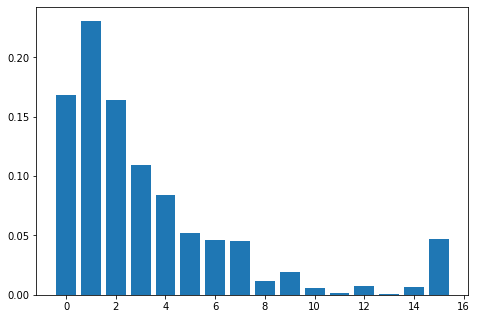

Time for epoch 141 is 10.275852918624878 sec


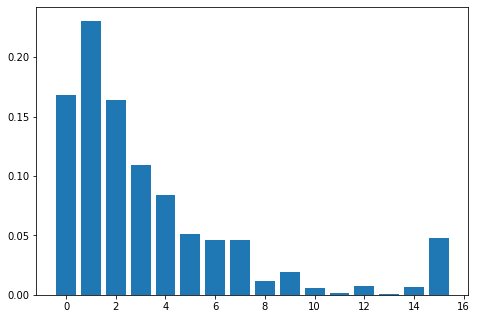

Time for epoch 142 is 10.30693507194519 sec


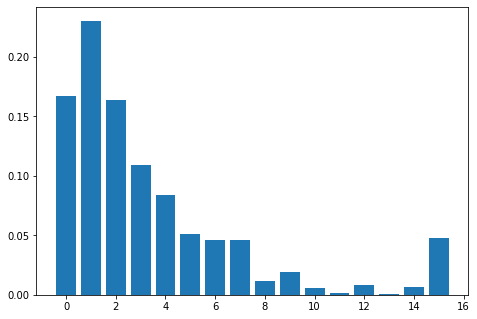

Time for epoch 143 is 11.098896026611328 sec


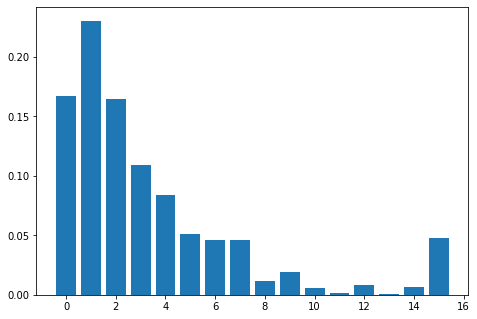

Time for epoch 144 is 10.736193895339966 sec


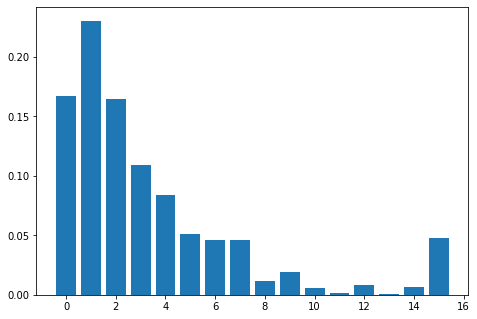

Time for epoch 145 is 10.553807735443115 sec


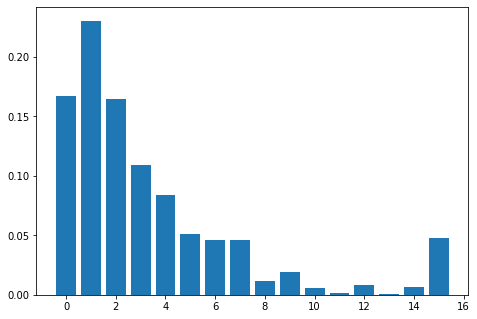

Time for epoch 146 is 10.687866687774658 sec


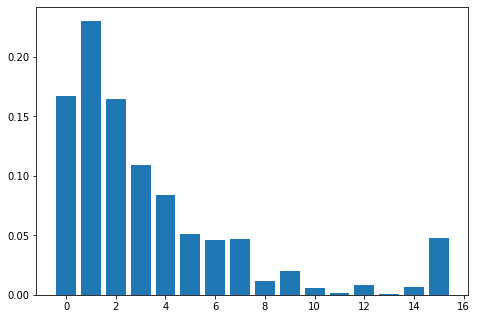

Time for epoch 147 is 10.51061487197876 sec


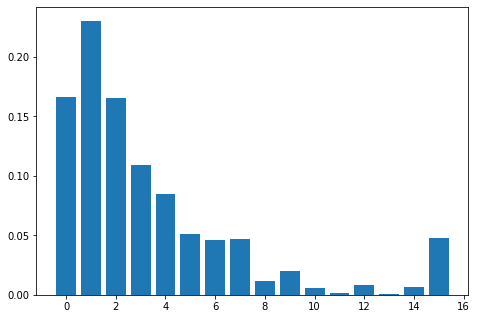

Time for epoch 148 is 10.573288679122925 sec


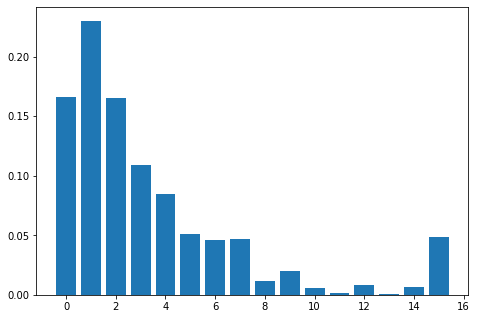

Time for epoch 149 is 10.419156312942505 sec


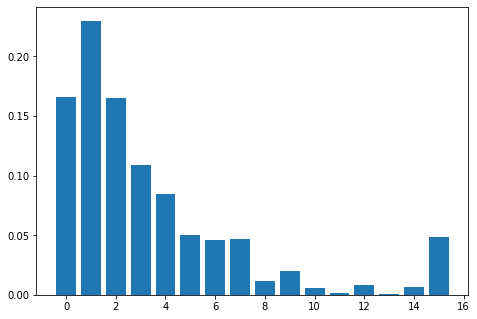

Time for epoch 150 is 10.622883319854736 sec


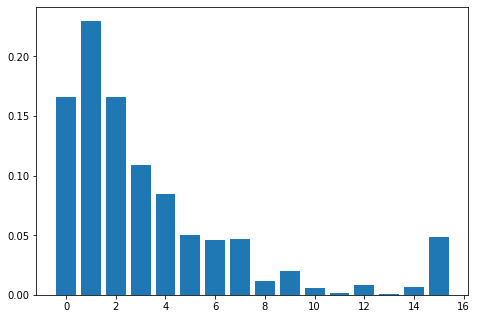

Time for epoch 151 is 12.087666749954224 sec


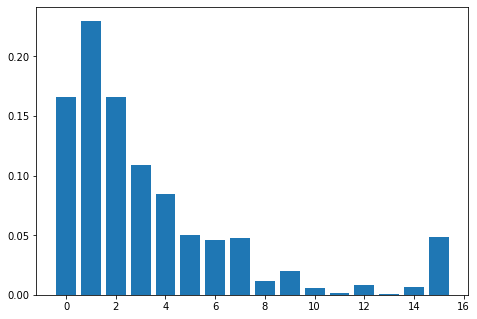

Time for epoch 152 is 10.781885862350464 sec


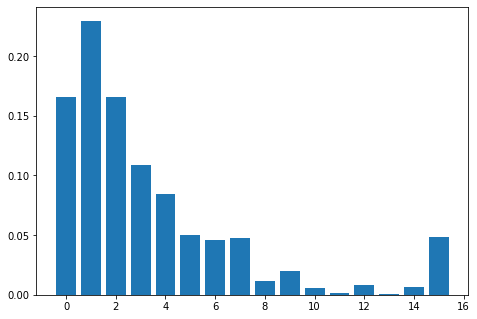

Time for epoch 153 is 11.263137578964233 sec


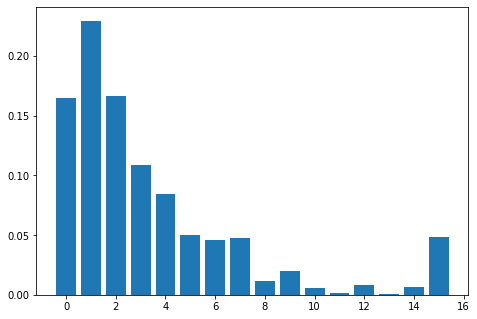

Time for epoch 154 is 11.913532257080078 sec


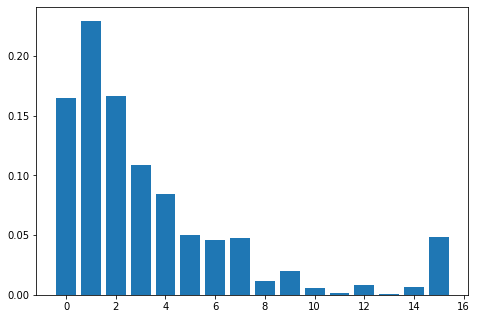

Time for epoch 155 is 11.14018201828003 sec


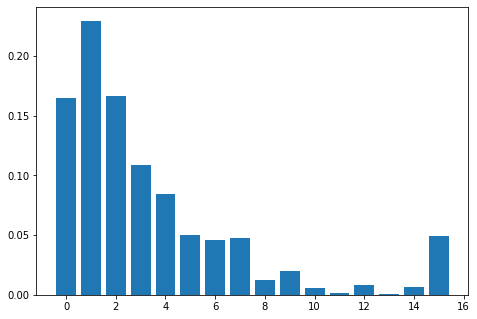

Time for epoch 156 is 10.776028633117676 sec


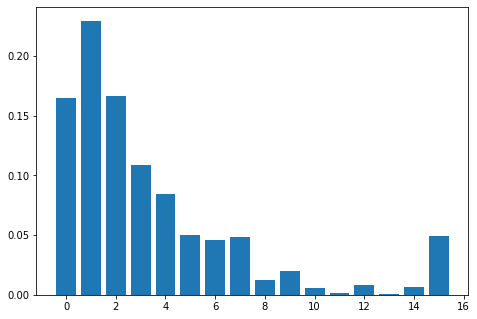

Time for epoch 157 is 10.848269701004028 sec


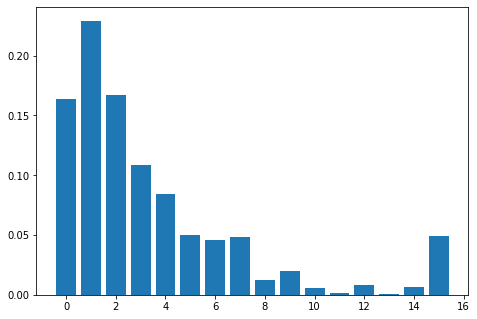

Time for epoch 158 is 10.532884120941162 sec


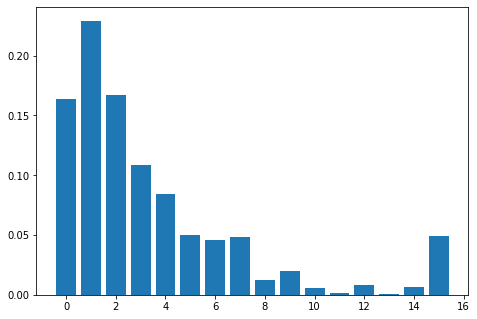

Time for epoch 159 is 10.443920850753784 sec


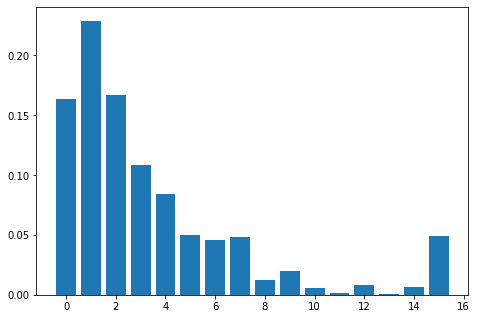

Time for epoch 160 is 10.85884714126587 sec


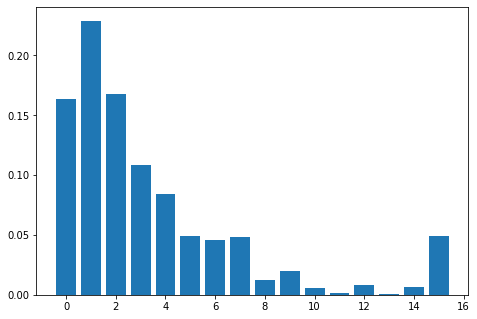

Time for epoch 161 is 10.852163076400757 sec


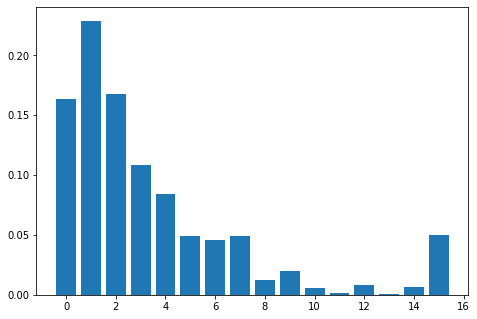

Time for epoch 162 is 11.434226989746094 sec


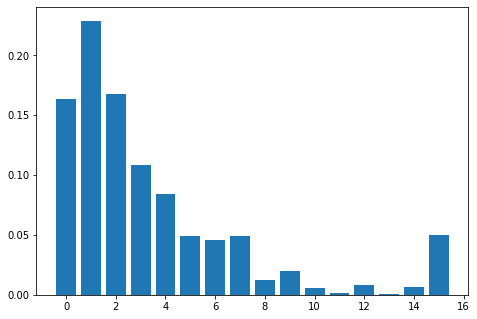

Time for epoch 163 is 11.799460649490356 sec


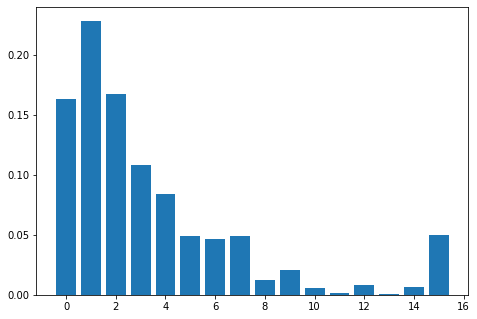

Time for epoch 164 is 11.020163536071777 sec


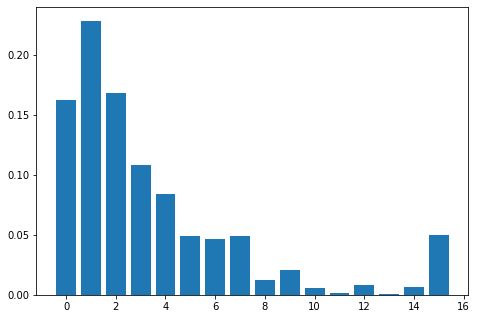

Time for epoch 165 is 10.510261297225952 sec


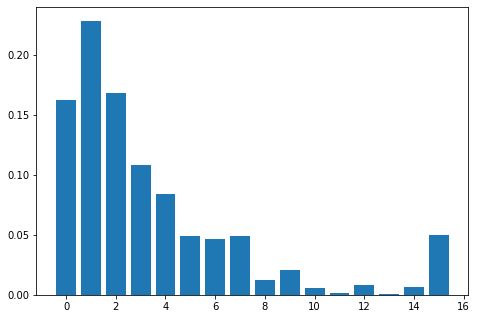

Time for epoch 166 is 10.603819847106934 sec


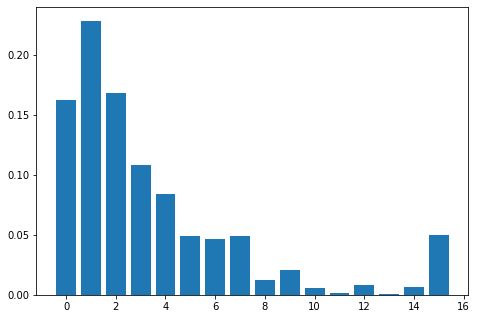

Time for epoch 167 is 10.338418006896973 sec


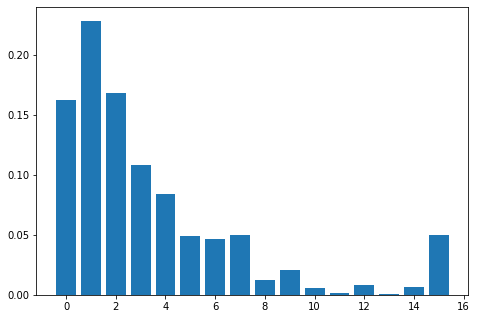

Time for epoch 168 is 11.365105152130127 sec


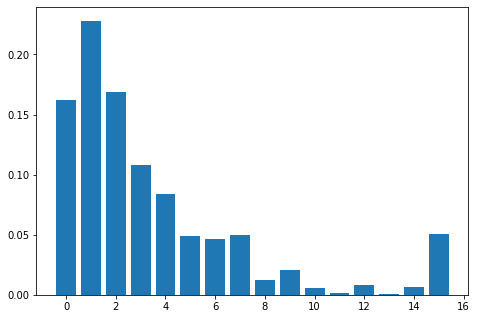

Time for epoch 169 is 10.816286325454712 sec


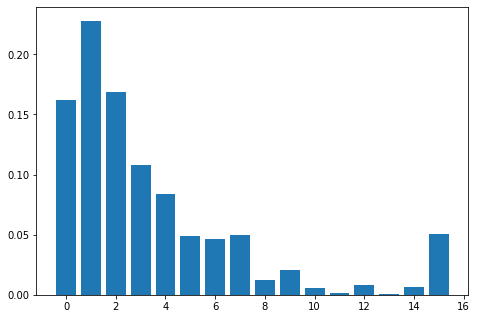

Time for epoch 170 is 10.329849481582642 sec


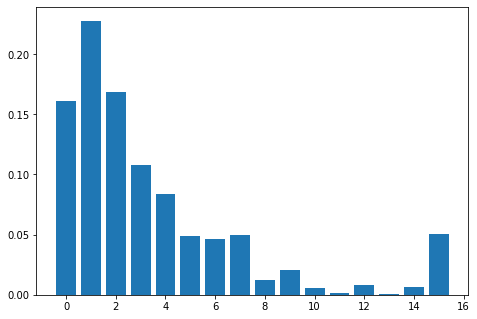

Time for epoch 171 is 10.49425745010376 sec


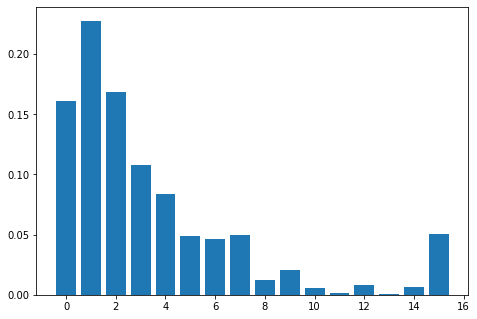

Time for epoch 172 is 10.474263429641724 sec


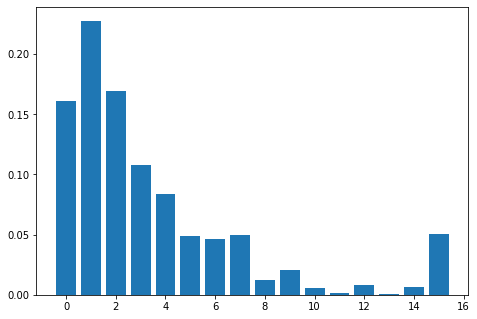

Time for epoch 173 is 10.491596221923828 sec


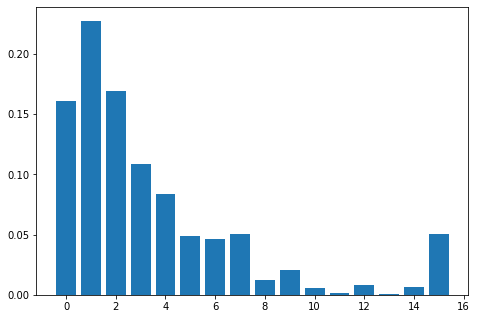

Time for epoch 174 is 11.641173124313354 sec


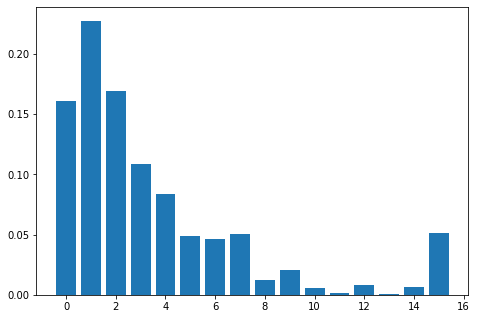

Time for epoch 175 is 11.095942735671997 sec


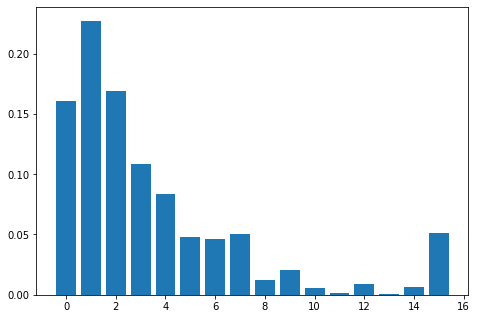

Time for epoch 176 is 10.81204104423523 sec


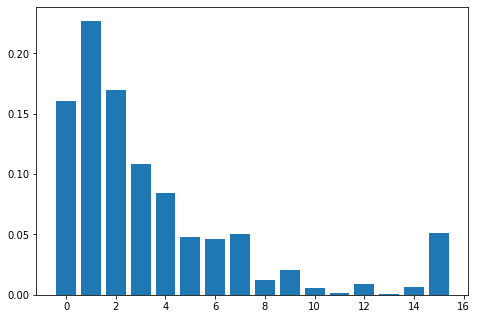

Time for epoch 177 is 10.589895486831665 sec


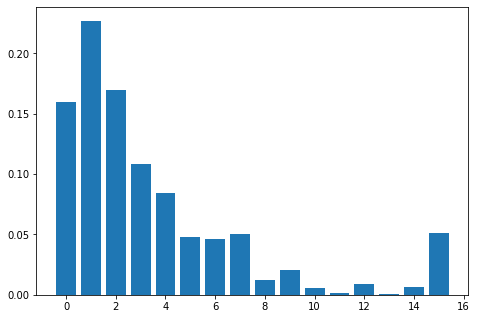

Time for epoch 178 is 10.609091758728027 sec


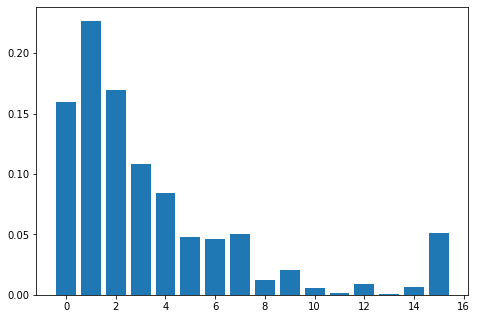

Time for epoch 179 is 10.269617319107056 sec


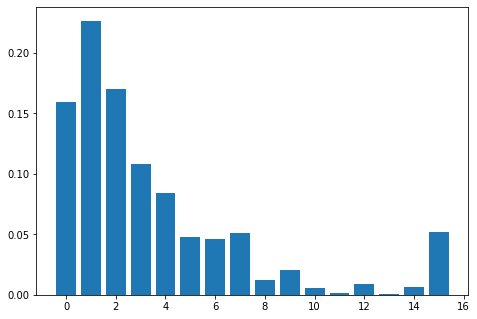

Time for epoch 180 is 10.489464521408081 sec


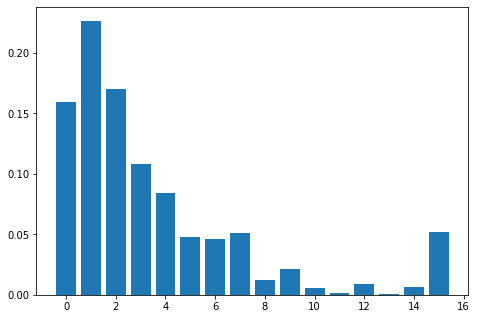

Time for epoch 181 is 10.45561957359314 sec


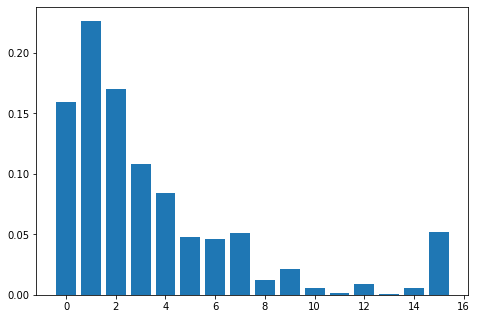

Time for epoch 182 is 10.38931941986084 sec


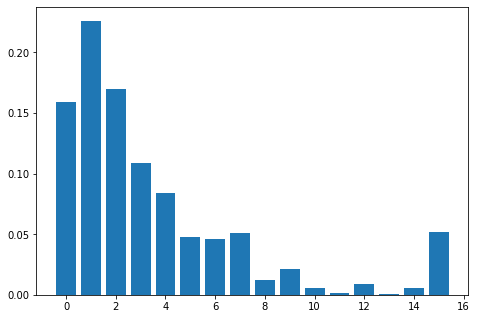

Time for epoch 183 is 10.356812953948975 sec


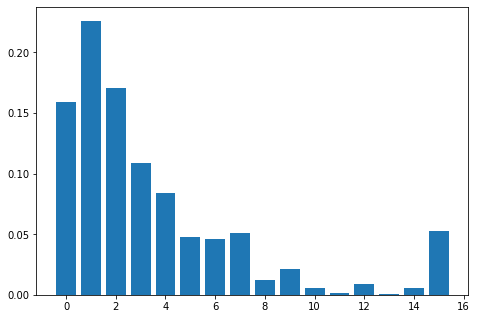

Time for epoch 184 is 10.446022987365723 sec


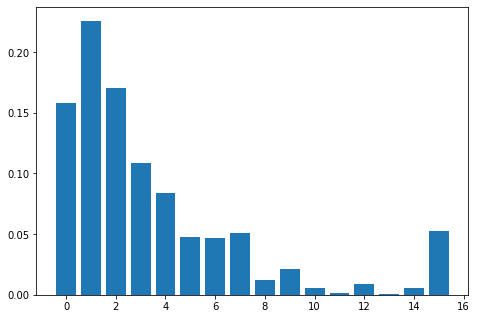

Time for epoch 185 is 10.343179702758789 sec


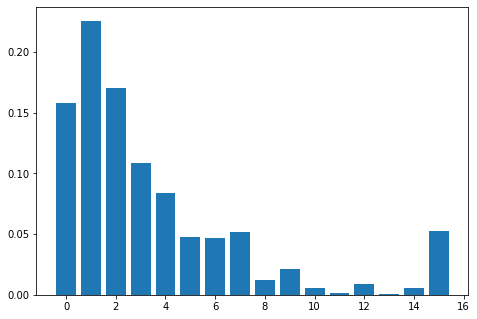

Time for epoch 186 is 10.541787147521973 sec


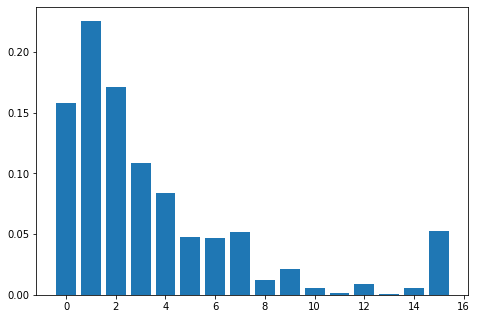

Time for epoch 187 is 12.368166208267212 sec


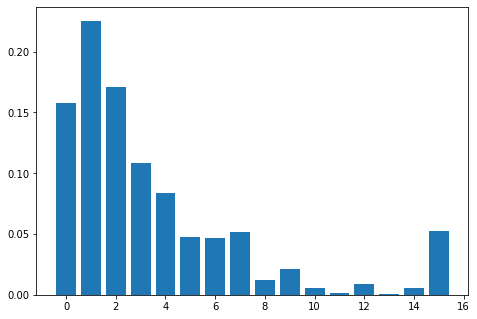

Time for epoch 188 is 11.358022212982178 sec


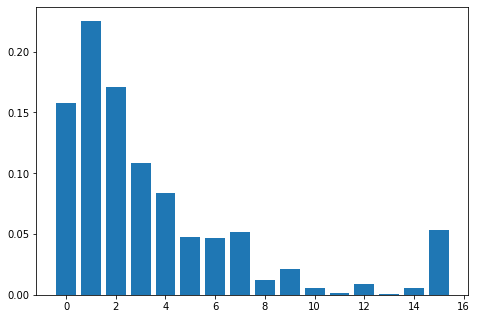

Time for epoch 189 is 10.919113874435425 sec


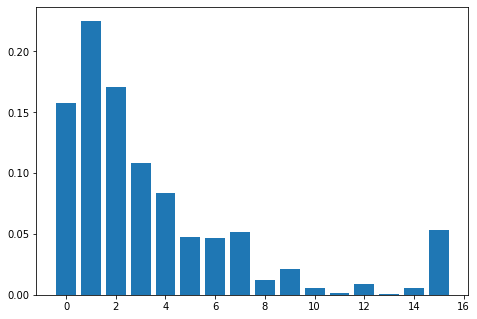

Time for epoch 190 is 10.523967266082764 sec


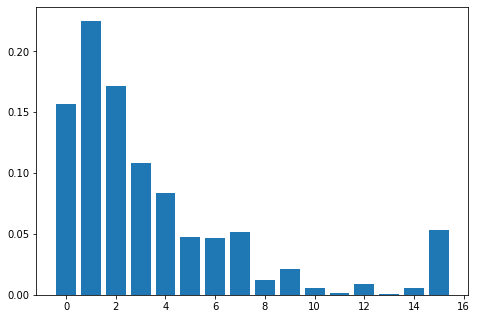

Time for epoch 191 is 10.432704210281372 sec


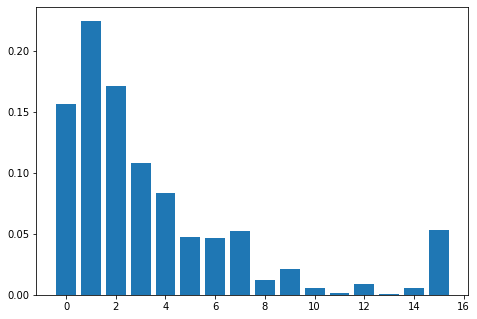

Time for epoch 192 is 10.405328512191772 sec


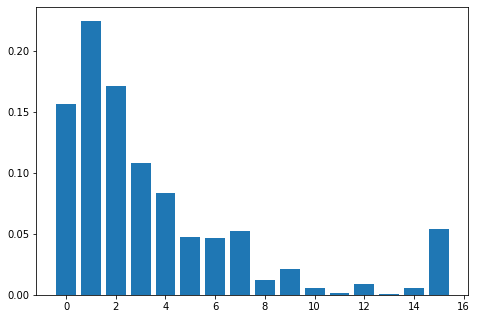

Time for epoch 193 is 10.576549053192139 sec


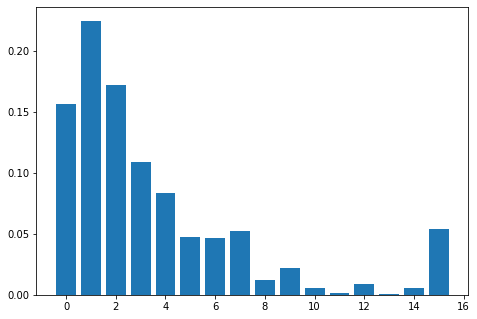

Time for epoch 194 is 10.333098649978638 sec


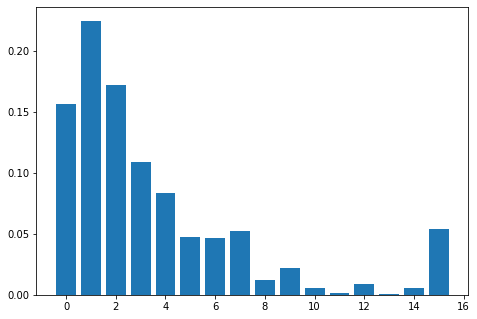

Time for epoch 195 is 10.4952073097229 sec


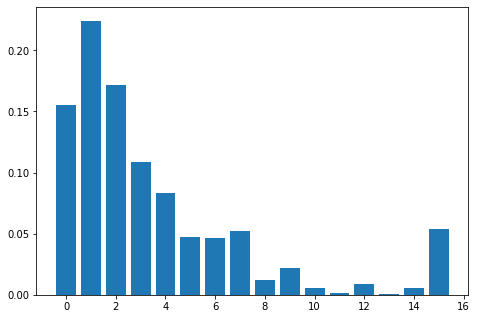

Time for epoch 196 is 10.818135499954224 sec


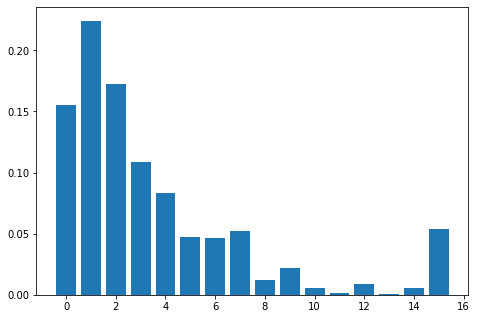

Time for epoch 197 is 10.394828796386719 sec


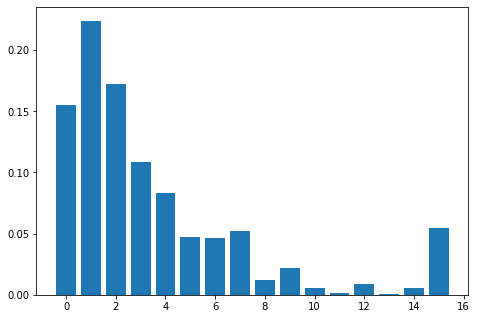

Time for epoch 198 is 10.553206443786621 sec


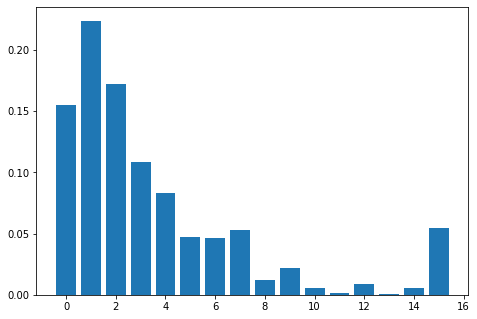

Time for epoch 199 is 10.725723505020142 sec


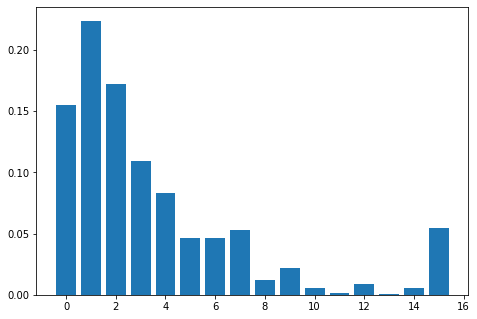

Time for epoch 200 is 11.043155193328857 sec


In [26]:
train(data_loader, EPOCHS)

In [27]:
noise = tf.random.normal([1, 4])
generated_data = generator(noise, training=False).numpy()
generated_data

array([[0.15460569, 0.22361676, 0.17249098, 0.10887774, 0.08314934,
        0.04668324, 0.04666705, 0.05279163, 0.01218568, 0.02189813,
        0.0056013 , 0.00114724, 0.00914939, 0.00058421, 0.00572308,
        0.05482855]])

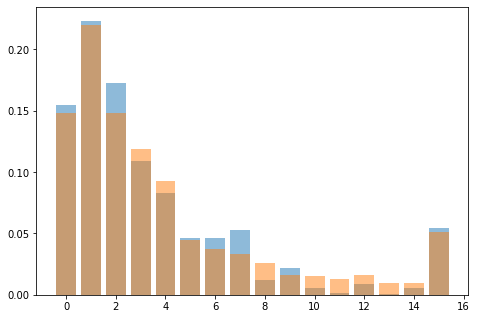

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, generated_data[0], alpha=0.5)
ax.bar(y, new_point, alpha=0.5)
plt.show()

In [29]:
generator.weights

[<tf.Variable 'sequential/keras_layer/weights:0' shape=(32,) dtype=float32, numpy=
 array([-0.1398612 , -0.36195645, -0.00780892, -0.34165868, -0.03530267,
         0.3815679 ,  0.28854313,  0.16803406, -0.11564549,  0.37992626,
        -0.58714056,  0.34056577,  0.02467708,  0.41444075,  0.11755896,
         0.2452789 ,  0.409245  , -0.75248414,  0.09989738, -0.1243085 ,
        -0.37932548, -0.5043638 ,  0.44260037, -0.12020979,  0.02797678,
        -0.12992726, -0.16434328, -0.10134229, -0.13927177,  0.16761073,
         0.161789  ,  0.17992342], dtype=float32)>]